<h1 style="font-size:50px; color:white;">Data Loading, Data visualization and initial data engineering</h1>

In [268]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import hamming_loss
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import LabelEncoder
from scipy.stats import zscore
from statsmodels import robust
import warnings
from collections import Counter

# Suppress user warnings to make the outputs cleaner to read
warnings.filterwarnings("ignore", category=UserWarning)
# Define directory path
directory_path = r"C:\Users\daddy\Downloads\nfl-big-data-bowl-2025"
# Load only the 'plays.csv' into a DataFrame
file_path = os.path.join(directory_path, 'plays.csv')
# Load the 'plays.csv' file into a DataFrame
try:
    plays_data = pd.read_csv(file_path)
    print(f"Loaded DataFrame: plays_data with shape {plays_data.shape}")
except Exception as e:
    print(f"Error loading {file_path}: {e}")

Loaded DataFrame: plays_data with shape (16124, 50)


<h1 style="font-size:50px; color:white;">Simple initial Data Engineering</h1>

In [269]:
#For fragmentation purposes and speed we define plays_data as p
p = plays_data
# Isolate the 'passResult' column as it is our eventual target
pass_result = p['passResult']
# Drop all columns with NaN values, excluding 'passResult'
p = p.dropna(axis=1)
p = p.copy()
# Add the 'passResult' column back
p['passResult'] = pass_result

In [270]:
# Now drop rows where 'passResult' column is NaN
p = p.dropna(subset=['passResult'])
#Copy the dataframe to avoid fragmentation
p = p.copy()
p = p.reset_index()

In [271]:
p.dtypes

index                                 int64
gameId                                int64
playId                                int64
playDescription                      object
quarter                               int64
down                                  int64
yardsToGo                             int64
possessionTeam                       object
defensiveTeam                        object
yardlineNumber                        int64
gameClock                            object
preSnapHomeScore                      int64
preSnapVisitorScore                   int64
playNullifiedByPenalty               object
absoluteYardlineNumber                int64
preSnapHomeTeamWinProbability       float64
preSnapVisitorTeamWinProbability    float64
expectedPoints                      float64
playAction                             bool
qbKneel                               int64
prePenaltyYardsGained                 int64
yardsGained                           int64
homeTeamWinProbabilityAdded     

<h1 style="font-size:50px; color:white;">Complex data cleaning, engineering + feature label encoding</h1>

In [272]:
L = list(p['playDescription'])

<h1 style="font-size:50px; color:white;">time extraction regex matches times formatted as MM:SS or :SS where the mathematical structure is an alternation between two patterns where the Union is represented by L(\d+:\d+∣:\d+)=L(\d+:\d+)∪L(:\d+).</h1>

<h1 style="font-size:50px; color:white;"> The Formation extraction regex pattern captures formations like "Shotgun", "No Huddle", or combinations of both.
The alternation operator | represents a union of possible formations</h1>

In [273]:
import re
import pandas as pd
# Function to extract components from each play description
def extract_play_info(play_description):
    # Step 1: Extract time (capture both MM:SS and (:SS) formats)
    time = re.search(r'\((\d+:\d+|:\d+)\)', play_description)  # Added (:SS) format
    time = time.group(1) if time else None
    # Step 2: Extract formation (identify "Shotgun", "No Huddle", etc., and insert "NoPass" if none of these are present)
    formation = re.search(r'\((No Huddle, Shotgun|Shotgun|No Huddle)\)', play_description)
    formation = formation.group(1) if formation else None

    # If no formation is found and no "pass", set formation to "NoPass"
    if not formation and 'pass' not in play_description:
        formation = 'NoPass'
    
    # Insert "Shotgun" if "pass" is present and no formation is found
    if not formation and 'pass' in play_description:
        formation = 'Shotgun'

    # Step 3: Extract quarterback's name (first "A.Lastname" pattern found)
    qb_name = re.search(r'([A-Z]\.\w+)', play_description)
    qb_name = qb_name.group(1) if qb_name else None

    # Step 4: Extract pass description (handle cases where pass description follows directly after QB or in other formats)
    pass_description = re.search(r'pass ([\w\s]+?) to', play_description)
    if not pass_description and qb_name:
        # If no "to" is found, capture directly after the QB's name
        pass_description = re.search(fr'{qb_name} pass ([\w\s]+?)(?: to|$)', play_description)
    
    pass_description = pass_description.group(1).strip() if pass_description else None
    
    # Remove 'incomplete' and 'complete' from pass description if present
    if pass_description:
        pass_description = re.sub(r'\b(incomplete|complete)\b', '', pass_description).strip()

    # If no pass description found, insert "NoPass"
    if not pass_description:
        pass_description = 'NoPass'

    # Step 5: Extract receiver's name (handle both parentheses and second name directly after QB)
    # Capture both the first instance of a name after "to" or intended for
    receiver_search = re.search(r'(to|intended for|for) ([A-Z]\.\w+)', play_description)
    receiver_name = receiver_search.group(2) if receiver_search else 'NoReception'

    # If the pass was incomplete or there's no clear receiver, set receiver_name to 'NoReception'
    if 'incomplete' in play_description or 'scrambles' in play_description:
        receiver_name = 'NoReception'
    
    # Step 6: Remove any information beyond the main receiver and clean up trailing details
    if receiver_name and receiver_name != 'NoReception':
        play_description_clean = re.split(r'(FUMBLES|challenged|Timeout)', play_description)[0]
        receiver_name = re.search(r'(to|intended for|for) ([A-Z]\.\w+)', play_description_clean)
        receiver_name = receiver_name.group(2) if receiver_name else 'NoReception'

    # Capture second name in parentheses if it appears after the first name (handles secondary names)
    secondary_name = re.search(r'\(([A-Z]\.\w+),?\s?([A-Z]\.\w+)?\)', play_description)
    if secondary_name:
        receiver_name = secondary_name.group(1)  # First receiver captured
        if secondary_name.group(2):
            receiver_name += f", {secondary_name.group(2)}"  # Handle cases with two receivers in parentheses

    return time, formation, qb_name, pass_description, receiver_name

# Example usage
L = list(p['playDescription'])

# Apply the extraction to every row in the list L
extracted_data = [extract_play_info(play) for play in L]

# Create a DataFrame with the extracted columns
columns = ['Time', 'Formation', 'Quarterback', 'Pass Description', 'Receiver']
df = pd.DataFrame(extracted_data, columns=columns)

In [274]:
p = p.drop(columns=['playDescription'])

# Add the new columns from df to p
columns = ['Time', 'Formation', 'Quarterback', 'Pass Description', 'Receiver']
p[columns] = df[columns]

In [275]:
# Define categorical columns to encode
label_columns = [
    'possessionTeam', 'defensiveTeam',
    'playNullifiedByPenalty', 'isDropback', 'playNullifiedByPenalty', 
    'defensiveTeam', 'passResult', 'Time', 'Formation', 'Quarterback', 'Pass Description', 'Receiver'
]
# Initialize the label encoder for all the categorical columns
le = LabelEncoder()

# Create a dictionary to hold the LabelEncoders for each column
label_encoders = {}

# Fit and transform all the categorical columns
for column in label_columns:
    label_encoders[column] = LabelEncoder()  # Create an encoder for each column
    label_encoders[column].fit(p[column].astype(str))  # Fit the encoder
    p[column] = label_encoders[column].transform(p[column].astype(str))  # Transform the column
# Print the mapping of original 'passResult' values to encoded integer labels so we know which classes correspond to which integers
le_pass_result = label_encoders['passResult']  # Get the encoder for 'passResult'
print("Mapping of original 'passResult' values to encoded integer labels:")
for index, label in enumerate(le_pass_result.classes_):
    print(f"{label} -> {index}")

Mapping of original 'passResult' values to encoded integer labels:
C -> 0
I -> 1
IN -> 2
R -> 3
S -> 4


#Showing the unique values of the passResult column which is our target in order to confirm and prove data integrity has been protected
# 0 = Complete pass outcomes
# 1 = Interception outcomes
# 2 = Sack outcomes
# 3 = Incomplete pass outcomes
# 4 = Scramble outcomes

In [276]:
# Convert bool columns where True becomes 0 and False becomes 1
bool_columns = ['playAction', 'isDropback']
# Invert the boolean values (True -> 0, False -> 1)
for col in bool_columns:
    p = p.copy()
    p[col] = p[col].apply(lambda x: 0 if x else 1)

In [277]:
# Function to group the gameClock into 5 bins
def group_game_clock(clock):
    minutes, seconds = map(int, clock.split(':'))  # Extract the minutes and seconds
    
    # Group based on specified minute ranges
    if 0 <= minutes < 3:       # 00:00 to 02:59
        return 0
    elif 3 <= minutes < 6:     # 03:00 to 05:59
        return 1
    elif 6 <= minutes < 9:     # 06:00 to 08:59
        return 2
    elif 9 <= minutes < 12:    # 09:00 to 11:59
        return 3
    else:                      # 12:00 to 15:00
        return 4
# Apply the grouping function to the 'gameClock' column
p['gameClockGrouped'] = p['gameClock'].apply(group_game_clock)

# Drop the 'gameClock' column as we no longer need it
p = p.drop('gameClock', axis=1)

In [278]:
p

index      gameId  playId  quarter  down  yardsToGo  possessionTeam  \
0         0  2022102302    2655        3     1         10               6   
1         1  2022091809    3698        4     1         10               6   
2         2  2022103004    3146        4     3         12              12   
3         3  2022110610     348        1     2         10              15   
4         8  2022091104    3662        4     3         12              25   
...     ...         ...     ...      ...   ...        ...             ...   
9731  16117  2022100901    2213        3     1         10              26   
9732  16119  2022110604    1051        2     3          4              14   
9733  16120  2022103005    3492        4     1         10              20   
9734  16121  2022092502    2337        3     1         10              15   
9735  16122  2022091809     719        1     1         10               8   

      defensiveTeam  yardlineNumber  preSnapHomeScore  ...  \
0                 1              21                35  ...   
1                30               8                17  ...   
2                24              20                 3  ...   
3                24              23                 0  ...   
4                 2              35                28  ...   
...             ...             ...               ...  ...   
9731             23              25                31  ...   
9732             10              31                 0  ...   
9733              0              25                28  ...   
9734              5              13                10  ...   
9735             28              47                 7  ...   

      expectedPointsAdded  isDropback  pff_runPassOption  passResult  Time  \
0                0.702717           1                  0           0   354   
1               -0.240509           1                  0           0   373   
2               -0.218480           1                  0           0   360   
3               -0.427749           1                  0           0   808   
4               -1.161621           1                  0           1   171   
...                   ...         ...                ...         ...   ...   
9731             1.512348           1                  0           0   299   
9732            -1.391687           1                  0           1   169   
9733            -0.503208           1                  0           1   152   
9734             1.073898           1                  0           3   839   
9735            -0.522397           1                  0           1   884   

      Formation  Quarterback  Pass Description  Receiver  gameClockGrouped  
0             3           40                 5       592                 0  
1             3           40                 6       499                 0  
2             3           29                 6       410                 0  
3             3           74                 4      1245                 3  
4             3           50                 6        11                 4  
...         ...          ...               ...       ...               ...  
9731          3           58                 3       330                 4  
9732          3           92                 6       975                 4  
9733          3           56                 0       975                 4  
9734          3           74                 0      1065                 3  
9735          3           21                 3       975                 0  

[9736 rows x 32 columns]

<h1 style="font-size:50px; color:white;">Feature Engineering centered around feature interactions </h1>

In [279]:
# Select only float columns, excluding 'passResult' to begin feature engineering
float_columns = p.select_dtypes(include=['float64']).drop(columns=['passResult'], errors='ignore')
# Create a copy of p to hold the interaction features to avoid fragmentation
p = p.copy()
# Loop over each pair of float columns and calculate the π interaction
for col1 in float_columns.columns:
    for col2 in float_columns.columns:
        if col1 != col2:  # Avoid self-interaction
            interaction_name = f'pi_interaction_{col1}_{col2}'
            p[interaction_name] = np.pi * (p[col1] * p[col2])

In [280]:
# Define the columns we want to calculate the derivatives for
columns_to_diff = [
    'preSnapHomeTeamWinProbability',
    'preSnapVisitorTeamWinProbability',
    'expectedPoints',
    'homeTeamWinProbabilityAdded',
    'visitorTeamWinProbilityAdded',
    'expectedPointsAdded'
]

# Initialize empty DataFrame to store the new derivative columns
derivative_cols = {}
# Iterate over each column and calculate the derivative based on passResult
for col in columns_to_diff:
    # Initialize a new column name for the derivative
    derivative_col_name = f'{col}_derivative'
    # Calculate the derivative for each unique class in passResult
    derivative_cols[derivative_col_name] = p.groupby('passResult')[col].diff()
# Convert the dictionary of derivative columns into a DataFrame
derivative_df = pd.DataFrame(derivative_cols)
p = p.copy()
# Concatenate the derivative DataFrame with the original DataFrame `p`
p = pd.concat([p, derivative_df], axis=1)
p = p.copy()
# Ensure the order of the dataset remains the same (this step is optional as groupby doesn't alter the order)
p = p.sort_index()
p = p.dropna(axis=0)
p = p.reset_index()

In [281]:
#Rolling Standard Deviation (Window size of 3 for example)
for col in columns_to_diff:
    rolling_std_col_name = f'{col}_rolling_std'
    p = p.copy()
    # Calculate the rolling standard deviation within each 'passResult' group
    p[rolling_std_col_name] = p.groupby('passResult')[col].rolling(window=3).std().reset_index(level=0, drop=True)

# Ensure the order of the dataset remains the same (this step is optional as groupby doesn't alter the order)
p = p.sort_index()
p = p.dropna(axis=0)
p = p.reset_index(drop=True)

In [282]:
# Exponential Moving Average (span=3 as an example)
for col in columns_to_diff:
    ema_col_name = f'{col}_ema'
    # Calculate the exponential moving average for each group
    p[ema_col_name] = p.groupby('passResult')[col].apply(lambda x: x.ewm(span=3, adjust=False).mean()).reset_index(level=0, drop=True)

# Drop rows where NaN values exist after the operation
p = p.dropna(axis=0)

# Ensure the DataFrame is ordered correctly (optional)
p = p.sort_index()
#p = p.reset_index(drop=True)

In [283]:
# Z-Score Normalization for each column
for col in columns_to_diff:
    zscore_col_name = f'{col}_zscore'
    # Apply z-score normalization per group and ensure index is aligned with the original DataFrame
    p[zscore_col_name] = p.groupby('passResult')[col].apply(lambda x: (x - x.mean()) / x.std()).reset_index(level=0, drop=True)

# Ensure that the DataFrame is not altered in terms of row order and index
# No need to reset or sort the index if it's not necessary
p = p.dropna(axis=0)
# Drop the 'level_0' and 'Index' columns from the DataFrame 'p'
p = p.drop(columns=['level_0', 'index'])
# Reset index only if necessary, to avoid issues with indexing later
p = p.reset_index(drop=True)

In [284]:
p

gameId  playId  quarter  down  yardsToGo  possessionTeam  \
0     2022110610     348        1     2         10              15   
1     2022100204    1422        2     3          8               8   
2     2022110603    2325        3     2          9              11   
3     2022100913    2604        3     3          6               6   
4     2022110607    3178        4     2          7              31   
...          ...     ...      ...   ...        ...             ...   
9716  2022100901    2213        3     1         10              26   
9717  2022110604    1051        2     3          4              14   
9718  2022103005    3492        4     1         10              20   
9719  2022092502    2337        3     1         10              15   
9720  2022091809     719        1     1         10               8   

      defensiveTeam  yardlineNumber  preSnapHomeScore  preSnapVisitorScore  \
0                24              23                 0                    0   
1                25              35                 6                    7   
2                 2              47                 8                    0   
3                12              20                13                   10   
4                13              28                17                   10   
...             ...             ...               ...                  ...   
9716             23              25                31                    3   
9717             10              31                 0                   10   
9718              0              25                28                   26   
9719              5              13                10                   14   
9720             28              47                 7                    3   

      ...  expectedPoints_ema  homeTeamWinProbabilityAdded_ema  \
0     ...            4.249382                        -0.001308   
1     ...            2.348692                         0.028591   
2     ...            2.326099                        -0.007901   
3     ...            3.065124                        -0.024550   
4     ...            1.901911                        -0.020428   
...   ...                 ...                              ...   
9716  ...            2.111241                         0.001097   
9717  ...            1.537280                        -0.017967   
9718  ...            1.568741                        -0.022273   
9719  ...            3.821542                         0.001031   
9720  ...            2.247526                        -0.016917   

      visitorTeamWinProbilityAdded_ema  expectedPointsAdded_ema  \
0                             0.001308                -0.427749   
1                            -0.028591                 0.883506   
2                             0.007901                 1.085102   
3                             0.024550                 1.194845   
4                             0.020428                 0.243007   
...                                ...                      ...   
9716                         -0.001097                 0.817491   
9717                          0.017967                -1.300705   
9718                          0.022273                -0.901956   
9719                         -0.001031                 0.472518   
9720                          0.016917                -0.712177   

      preSnapHomeTeamWinProbability_zscore  \
0                                 1.149014   
1                                -0.035619   
2                                 0.369571   
3                                -0.031061   
4                                 0.982897   
...                                    ...   
9716                              1.526088   
9717                             -1.154272   
9718                              0.622508   
9719                             -1.395544   
9720                             -0.081270   

      preSnapVisitorTeamWinProbability_zscore  expectedPoints_zscore  \
0        

In [285]:
from scipy.stats import skew, kurtosis

# Define the rolling window size
window_size = 5

# Optimized function to calculate rolling statistics for each column directly into 'p'
def calculate_rolling_features_fast(df, window_size):
    float_columns = df.select_dtypes(include=['float64', 'float32']).columns
    
    for col in float_columns:
        # Use built-in pandas methods for mean and variance
        df[f'{col}_rolling_mean'] = df[col].rolling(window=window_size).mean()
        df = df.copy()
        df[f'{col}_rolling_variance'] = df[col].rolling(window=window_size).var()
        df = df.copy()
        # Convert column into a rolling 2D NumPy array for efficient processing
        rolling_matrix = np.lib.stride_tricks.sliding_window_view(df[col].dropna(), window_shape=window_size)
        df = df.copy()
        # Use NumPy's vectorized operations for skewness and kurtosis
        df[f'{col}_rolling_skewness'] = np.concatenate([np.full(window_size - 1, np.nan), skew(rolling_matrix, axis=1)])
        df = df.copy()
        df[f'{col}_rolling_kurtosis'] = np.concatenate([np.full(window_size - 1, np.nan), kurtosis(rolling_matrix, axis=1)])
        df = df.copy()
    return df
p = p.copy()
# Directly modify the original DataFrame 'p'
calculate_rolling_features_fast(p, window_size)
p = p.copy()
# Drop rows with NaN values after rolling calculations and reset index
p = p.dropna(axis=0).reset_index(drop=True)
p

gameId  playId  quarter  down  yardsToGo  possessionTeam  \
0     2022110607    3178        4     2          7              31   
1     2022100207     681        1     1         10              30   
2     2022092505    3437        4     3          6              21   
3     2022091111     923        2     1         10              17   
4     2022092506    1412        2     1          4               6   
...          ...     ...      ...   ...        ...             ...   
9712  2022100901    2213        3     1         10              26   
9713  2022110604    1051        2     3          4              14   
9714  2022103005    3492        4     1         10              20   
9715  2022092502    2337        3     1         10              15   
9716  2022091809     719        1     1         10               8   

      defensiveTeam  yardlineNumber  preSnapHomeScore  preSnapVisitorScore  \
0                13              28                17                   10   
1                 5              42                 0                    7   
2                12              33                26                   31   
3                10              47                 3                    3   
4                17               4                 6                   14   
...             ...             ...               ...                  ...   
9712             23              25                31                    3   
9713             10              31                 0                   10   
9714              0              25                28                   26   
9715              5              13                10                   14   
9716             28              47                 7                    3   

      ...  homeTeamWinProbabilityAdded_ema  visitorTeamWinProbilityAdded_ema  \
0     ...                        -0.020428                          0.020428   
1     ...                        -0.036073                          0.036073   
2     ...                        -0.050028                          0.050028   
3     ...                        -0.001011                          0.001011   
4     ...                         0.000298                         -0.000298   
...   ...                              ...                               ...   
9712  ...                         0.001097                         -0.001097   
9713  ...                        -0.017967                          0.017967   
9714  ...                        -0.022273                          0.022273   
9715  ...                         0.001031                         -0.001031   
9716  ...                        -0.016917                          0.016917   

      expectedPointsAdded_ema  preSnapHomeTeamWinProbability_zscore  \
0                    0.243007                              0.982897   
1                    0.840626                             -0.700503   
2                   -0.381737                             -1.132134   
3                    1.050897                              0.271714   
4                   -0.402760                             -1.568124   
...                       ...                                   ...   
9712                 0.817491                              1.526088   
9713                -1.300705                             -1.154272   
9714                -0.901956                              0.622508   
9715                 0.472518                             -1.395544   
9716                -0.712177                             -0.081270   

      preSnapVisitorTeamWinProbability_zscore  expectedPoints_zscore  \
0                                   -0.982897              -0.802360   
1                                    0.700503               0.862366   
2                                    1.132134              -0.953916   
3                                   -0.271714               0.274122   
4                                    1.568124             

In [286]:
p=p.dropna(axis=0)
p

gameId  playId  quarter  down  yardsToGo  possessionTeam  \
0     2022110607    3178        4     2          7              31   
1     2022100207     681        1     1         10              30   
2     2022092505    3437        4     3          6              21   
3     2022091111     923        2     1         10              17   
4     2022092506    1412        2     1          4               6   
...          ...     ...      ...   ...        ...             ...   
9712  2022100901    2213        3     1         10              26   
9713  2022110604    1051        2     3          4              14   
9714  2022103005    3492        4     1         10              20   
9715  2022092502    2337        3     1         10              15   
9716  2022091809     719        1     1         10               8   

      defensiveTeam  yardlineNumber  preSnapHomeScore  preSnapVisitorScore  \
0                13              28                17                   10   
1                 5              42                 0                    7   
2                12              33                26                   31   
3                10              47                 3                    3   
4                17               4                 6                   14   
...             ...             ...               ...                  ...   
9712             23              25                31                    3   
9713             10              31                 0                   10   
9714              0              25                28                   26   
9715              5              13                10                   14   
9716             28              47                 7                    3   

      ...  homeTeamWinProbabilityAdded_ema  visitorTeamWinProbilityAdded_ema  \
0     ...                        -0.020428                          0.020428   
1     ...                        -0.036073                          0.036073   
2     ...                        -0.050028                          0.050028   
3     ...                        -0.001011                          0.001011   
4     ...                         0.000298                         -0.000298   
...   ...                              ...                               ...   
9712  ...                         0.001097                         -0.001097   
9713  ...                        -0.017967                          0.017967   
9714  ...                        -0.022273                          0.022273   
9715  ...                         0.001031                         -0.001031   
9716  ...                        -0.016917                          0.016917   

      expectedPointsAdded_ema  preSnapHomeTeamWinProbability_zscore  \
0                    0.243007                              0.982897   
1                    0.840626                             -0.700503   
2                   -0.381737                             -1.132134   
3                    1.050897                              0.271714   
4                   -0.402760                             -1.568124   
...                       ...                                   ...   
9712                 0.817491                              1.526088   
9713                -1.300705                             -1.154272   
9714                -0.901956                              0.622508   
9715                 0.472518                             -1.395544   
9716                -0.712177                             -0.081270   

      preSnapVisitorTeamWinProbability_zscore  expectedPoints_zscore  \
0                                   -0.982897              -0.802360   
1                                    0.700503               0.862366   
2                                    1.132134              -0.953916   
3                                   -0.271714               0.274122   
4                                    1.568124             

<h1 style="font-size:50px; color:white;">Commencing data splitting in order to create an extensive repository of unseen data for the trained and saved model structure to be loaded up on to prove model accuracy, model generalization ability, lack of overfitting and consistent results from training and testing</h1>

In [287]:
# Assuming the column containing the classes is named 'passResultEncoded'
class_column = 'passResult'
# Filter the data to include only the first 5000 rows before grouping and sampling
p_first_5000 = p[p.index < 5000]
p_confirmation = p_first_5000.groupby(class_column).apply(lambda x: x.sample(6, random_state=42)).reset_index(drop=True)
# Drop the sampled rows from 'p' (use the index of p_confirmation to drop those rows)
p = p.drop(p_confirmation.index)
p = p.reset_index(drop=True)
p

gameId  playId  quarter  down  yardsToGo  possessionTeam  \
0     2022092503    3006        4     3          9               3   
1     2022101604    3174        4     1         10              19   
2     2022102000    1707        2     2          2              22   
3     2022101600    1215        2     2          9              28   
4     2022091500    2436        3     2          8              17   
...          ...     ...      ...   ...        ...             ...   
9682  2022100901    2213        3     1         10              26   
9683  2022110604    1051        2     3          4              14   
9684  2022103005    3492        4     1         10              20   
9685  2022092502    2337        3     1         10              15   
9686  2022091809     719        1     1         10               8   

      defensiveTeam  yardlineNumber  preSnapHomeScore  preSnapVisitorScore  \
0                11              25                14                   17   
1                13              31                 3                   16   
2                 0              33                20                   14   
3                 1              14                14                    7   
4                 7              27                14                   17   
...             ...             ...               ...                  ...   
9682             23              25                31                    3   
9683             10              31                 0                   10   
9684              0              25                28                   26   
9685              5              13                10                   14   
9686             28              47                 7                    3   

      ...  homeTeamWinProbabilityAdded_ema  visitorTeamWinProbilityAdded_ema  \
0     ...                        -0.104176                          0.104176   
1     ...                        -0.048658                          0.048658   
2     ...                        -0.022215                          0.022215   
3     ...                        -0.075911                          0.075911   
4     ...                        -0.038109                          0.038109   
...   ...                              ...                               ...   
9682  ...                         0.001097                         -0.001097   
9683  ...                        -0.017967                          0.017967   
9684  ...                        -0.022273                          0.022273   
9685  ...                         0.001031                         -0.001031   
9686  ...                        -0.016917                          0.016917   

      expectedPointsAdded_ema  preSnapHomeTeamWinProbability_zscore  \
0                    1.115371                             -1.041891   
1                    0.967510                             -1.565028   
2                    0.434729                              0.626128   
3                    1.768429                              0.080238   
4                    0.914932                             -0.271528   
...                       ...                                   ...   
9682                 0.817491                              1.526088   
9683                -1.300705                             -1.154272   
9684                -0.901956                              0.622508   
9685                 0.472518                             -1.395544   
9686                -0.712177                             -0.081270   

      preSnapVisitorTeamWinProbability_zscore  expectedPoints_zscore  \
0                                    1.041891               0.689562   
1                                    1.565028               1.215190   
2                                   -0.626128              -0.852200   
3                                   -0.080238               1.524108   
4                                    0.271528             

In [288]:
p_unseen = p.iloc[7281:9319, :]
p_prove = p.iloc[9320:9581, :]
p_realistic = p.iloc[9582:9673, :]
p_realgame = p.iloc[-1:, :]
p_realgame2 = p.iloc[9674:9675, :]
p_realgame3 = p.iloc[9675:9676, :]
p_realgame4 = p.iloc[9676:9677, :]
p_realgame5 = p.iloc[9677:9678, :]
p_realgame6 = p.iloc[9678:9679, :]
p_realgame7 = p.iloc[9679:9680, :]
p_realgame8 = p.iloc[9680:9681, :]
p_realgame9 = p.iloc[9681:9682, :]
p_realgame10 = p.iloc[9682:9683, :]
p_realgame11 = p.iloc[9683:9684, :]
p_realgame12 = p.iloc[9684:9685, :]
p = p.iloc[:7280, :]
p = p.dropna(axis=0)
p

gameId  playId  quarter  down  yardsToGo  possessionTeam  \
0     2022092503    3006        4     3          9               3   
1     2022101604    3174        4     1         10              19   
2     2022102000    1707        2     2          2              22   
3     2022101600    1215        2     2          9              28   
4     2022091500    2436        3     2          8              17   
...          ...     ...      ...   ...        ...             ...   
7275  2022102309    4082        4     3          5              17   
7276  2022100300     913        2     3          6              28   
7277  2022091104    3307        3     2          6              10   
7278  2022110610    2999        4     2          8              30   
7279  2022110700     971        2     3          4               2   

      defensiveTeam  yardlineNumber  preSnapHomeScore  preSnapVisitorScore  \
0                11              25                14                   17   
1                13              31                 3                   16   
2                 0              33                20                   14   
3                 1              14                14                    7   
4                 7              27                14                   17   
...             ...             ...               ...                  ...   
7275             20               5                16                   37   
7276              8              43                 7                    3   
7277             18              29                21                   38   
7278              7              12                 9                   17   
7279             15              39                 0                    7   

      ...  homeTeamWinProbabilityAdded_ema  visitorTeamWinProbilityAdded_ema  \
0     ...                        -0.104176                          0.104176   
1     ...                        -0.048658                          0.048658   
2     ...                        -0.022215                          0.022215   
3     ...                        -0.075911                          0.075911   
4     ...                        -0.038109                          0.038109   
...   ...                              ...                               ...   
7275  ...                         0.013853                         -0.013853   
7276  ...                        -0.011524                          0.011524   
7277  ...                         0.010340                         -0.010340   
7278  ...                         0.002276                         -0.002276   
7279  ...                        -0.014713                          0.014713   

      expectedPointsAdded_ema  preSnapHomeTeamWinProbability_zscore  \
0                    1.115371                             -1.041891   
1                    0.967510                             -1.565028   
2                    0.434729                              0.626128   
3                    1.768429                              0.080238   
4                    0.914932                             -0.271528   
...                       ...                                   ...   
7275                -0.174373                             -1.875815   
7276                -1.345095                              0.503318   
7277                 0.973505                             -1.791377   
7278                -0.251698                             -0.452082   
7279                 1.271960                             -0.833084   

      preSnapVisitorTeamWinProbability_zscore  expectedPoints_zscore  \
0                                    1.041891               0.689562   
1                                    1.565028               1.215190   
2                                   -0.626128              -0.852200   
3                                   -0.080238               1.524108   
4                                    0.271528             

<h1 style="font-size:50px; color:whitek;">Constructing an XGBoost classifier by which addresses class imbalancing between the 5 target labels in passResult (Complete, Intercepted, Sack, Incomplete, Scramble) as well as oversamples the Incomplete passes class or the class 3 in order to force the model to pay closer attention to the class as it was originally under-represented in the models predictional accuracy. We then print model performance metrics to analyze the models performance from testing as well as save the models weights and physical structure. </h1>

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       828
           1       1.00      1.00      1.00       895
           2       1.00      1.00      1.00       816
           3       1.00      1.00      1.00      8025
           4       1.00      1.00      1.00       833

    accuracy                           1.00     11397
   macro avg       1.00      1.00      1.00     11397
weighted avg       1.00      1.00      1.00     11397

Confusion Matrix:
 [[ 826    2    0    0    0]
 [   0  895    0    0    0]
 [   0    0  816    0    0]
 [   0    0    0 8025    0]
 [   0    0    0    0  833]]
Class Percentages:  {0: 99.7584541062802, 1: 100.0, 2: 100.0, 3: 100.0, 4: 100.0}


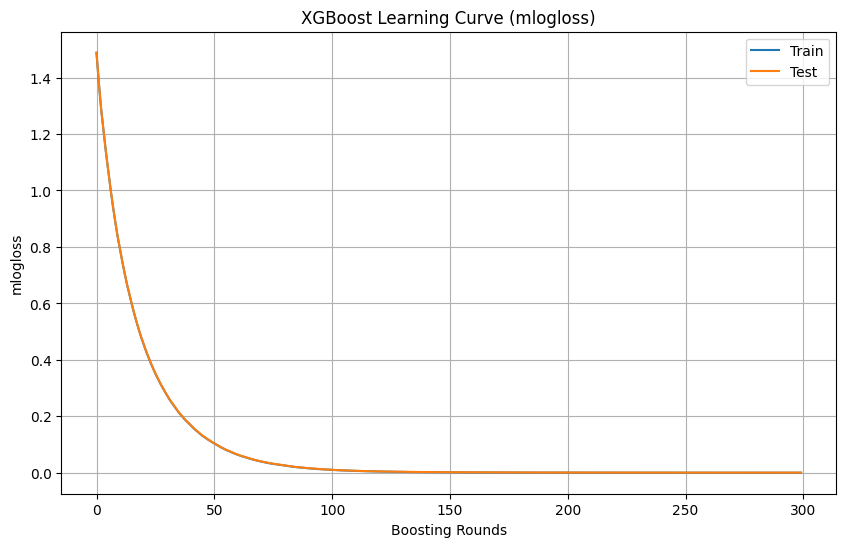

Model saved to xgb_model_no_overfitting.bin


In [289]:
# Define passResult as the target variable
target = 'passResult'
# Split the data into features (X) and target (y)
X = p.drop(columns=[target])
y = p[target]
# Address the data imbalance using SMOTE (Synthetic Minority Oversampling Technique)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
# Further increase samples of class 3 using RandomOverSampler
oversample = RandomOverSampler(sampling_strategy={3: int(y_resampled.value_counts()[3] * 9.5)}, random_state=42)
X_resampled, y_resampled = oversample.fit_resample(X_resampled, y_resampled)

# You can also use undersampling if needed. Here's an example (commented out for reference):
# undersample = RandomUnderSampler(sampling_strategy={3: int(y_resampled.value_counts()[3] * 0.5)}, random_state=42)
# X_resampled, y_resampled = undersample.fit_resample(X_resampled, y_resampled)

# Split the resampled data into training and test sets with an 80-20 split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Convert the data into DMatrix format for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set the parameters for the XGBoost model with regularization
params = {
    'objective': 'multi:softmax',  # Define the multi-class classification structure
    'num_class': len(y.unique()),  # Define the number of classes
    'learning_rate': 0.05, #Define the models learning rate
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.7,  # L1 regularization
    'reg_lambda': 0.7,  # L2 regularization
    'eval_metric': 'mlogloss'
}

# Store the evaluation results manually to ensure correct analysis of the model
evals_result = {}
# Watchlist to evaluate the performance on the test set
watchlist = [(dtrain, 'train'), (dtest, 'eval')]
# Train the model with early stopping to mitigate overfitting
bst = xgb.train(
    params, 
    dtrain, 
    num_boost_round=300,  # Defining the maximum number of boosting rounds
    evals=watchlist, 
    early_stopping_rounds=20,  # Stop if there is no improvement after 20 rounds
    verbose_eval=False,
    evals_result=evals_result  # Collect the evaluation results manually
)

# Predict on the test set using the trained model
y_pred = bst.predict(dtest)

# Generate a classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

# Generate a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Manual percentage count of the performance for each class
unique_classes = sorted(y_test.unique())
class_percentages = {}

for cls in unique_classes:
    total_count = sum(y_test == cls)
    correct_predictions = sum((y_test == cls) & (y_pred == cls))
    class_percentages[cls] = (correct_predictions / total_count) * 100

print("Class Percentages: ", class_percentages)

# Plot the learning curve of 'mlogloss' for training and validation sets to confirm learning curve is normalized
epochs = len(evals_result['train']['mlogloss'])
x_axis = range(0, epochs)

plt.figure(figsize=(10, 6))
plt.plot(x_axis, evals_result['train']['mlogloss'], label='Train')
plt.plot(x_axis, evals_result['eval']['mlogloss'], label='Test')
plt.xlabel('Boosting Rounds')
plt.ylabel('mlogloss')
plt.title('XGBoost Learning Curve (mlogloss)')
plt.legend()
plt.grid(True)
plt.show()
# Save the trained model to avoid retraining and establish the models intelligence that will be used to predict the future (trained model weights)
model_filename = "xgb_model_no_overfitting.bin"
bst.save_model(model_filename)
print(f"Model saved to {model_filename}")

<h1 style="font-size:50px; color:white;">Evaluation metrics of the models' 
predictive performance on the initial testing data to assess how well the model learned to do its job</h1>

In [290]:
from statsmodels.stats.diagnostic import het_breuschpagan, het_goldfeldquandt
from statsmodels.api import OLS, add_constant
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    cohen_kappa_score, matthews_corrcoef, hamming_loss, jaccard_score,
    balanced_accuracy_score, zero_one_loss, fowlkes_mallows_score, 
    adjusted_mutual_info_score, adjusted_rand_score, normalized_mutual_info_score,
    mean_squared_error, mean_absolute_error, explained_variance_score,
    r2_score, median_absolute_error, mutual_info_score, v_measure_score,
    completeness_score, homogeneity_score
)
# 1. Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# 2. Precision (Macro Average)
precision = precision_score(y_test, y_pred, average='macro')
print("Precision (Macro):", precision)

# 3. Recall (Macro Average)
recall = recall_score(y_test, y_pred, average='macro')
print("Recall (Macro):", recall)

# 4. F1 Score (Macro Average)
f1 = f1_score(y_test, y_pred, average='macro')
print("F1 Score (Macro):", f1)

# 5. Cohen's Kappa
kappa = cohen_kappa_score(y_test, y_pred)
print("Cohen's Kappa:", kappa)

# 6. Matthews Correlation Coefficient (MCC)
mcc = matthews_corrcoef(y_test, y_pred)
print("Matthews Correlation Coefficient:", mcc)

# 7. Hamming Loss
h_loss = hamming_loss(y_test, y_pred)
print("Hamming Loss:", h_loss)

# 8. Jaccard Score (Macro Average)
jaccard = jaccard_score(y_test, y_pred, average='macro')
print("Jaccard Score (Macro):", jaccard)

# 9. Balanced Accuracy
balanced_acc = balanced_accuracy_score(y_test, y_pred)
print("Balanced Accuracy:", balanced_acc)

# 10. Zero-One Loss
zero_one = zero_one_loss(y_test, y_pred)
print("Zero-One Loss:", zero_one)

# 11. Fowlkes-Mallows Index (FMI)
fmi = fowlkes_mallows_score(y_test, y_pred)
print("Fowlkes-Mallows Index:", fmi)

# 12. Adjusted Mutual Information (AMI)
ami = adjusted_mutual_info_score(y_test, y_pred)
print("Adjusted Mutual Information (AMI):", ami)

# 13. Adjusted Rand Index (ARI)
ari = adjusted_rand_score(y_test, y_pred)
print("Adjusted Rand Index (ARI):", ari)

# 14. Normalized Mutual Information (NMI)
nmi = normalized_mutual_info_score(y_test, y_pred)
print("Normalized Mutual Information (NMI):", nmi)

# 15. Mean Squared Error (MSE) - for analyzing prediction errors
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)

# 16. Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)

# 17. Explained Variance Score
explained_variance = explained_variance_score(y_test, y_pred)
print("Explained Variance Score:", explained_variance)

# 18. R² Score (Coefficient of Determination)
r2 = r2_score(y_test, y_pred)
print("R² Score (Coefficient of Determination):", r2)

# 19. Median Absolute Error
med_ae = median_absolute_error(y_test, y_pred)
print("Median Absolute Error:", med_ae)

# 20. Mutual Information Score
mi = mutual_info_score(y_test, y_pred)
print("Mutual Information Score:", mi)

# 21. V-Measure Score
v_measure = v_measure_score(y_test, y_pred)
print("V-Measure Score:", v_measure)

# 22. Completeness Score
completeness = completeness_score(y_test, y_pred)
print("Completeness Score:", completeness)

# 23. Homogeneity Score
homogeneity = homogeneity_score(y_test, y_pred)
print("Homogeneity Score:", homogeneity)

# --- Heteroskedasticity Test ---

# For heteroskedasticity tests, we need to fit a regression model on residuals
# Add a constant term to the input data (necessary for regression models)
X_test_with_const = add_constant(X_test)

# Fit an Ordinary Least Squares (OLS) model using statsmodels
ols_model = OLS(y_test - y_pred, X_test_with_const).fit()

# 24. Breusch-Pagan Test for Heteroskedasticity
bp_test = het_breuschpagan(ols_model.resid, ols_model.model.exog)
print(f"Breusch-Pagan Test: LM Stat={bp_test[0]}, p-value={bp_test[1]}")
# 25. Goldfeld-Quandt Test for Heteroskedasticity
gq_test = het_goldfeldquandt(ols_model.resid, ols_model.model.exog)
print(f"Goldfeld-Quandt Test: F-Stat={gq_test[0]}, p-value={gq_test[1]}")

Accuracy: 0.9998245152233044
Precision (Macro): 0.9995540691192865
Recall (Macro): 0.9995169082125603
F1 Score (Macro): 0.9995349477457246
Cohen's Kappa: 0.9996361372274429
Matthews Correlation Coefficient: 0.9996362010590164
Hamming Loss: 0.00017548477669562167
Jaccard Score (Macro): 0.9990709773318468
Balanced Accuracy: 0.9995169082125603
Zero-One Loss: 0.00017548477669560025
Fowlkes-Mallows Index: 0.9999488069755423
Adjusted Mutual Information (AMI): 0.9987804644900208
Adjusted Rand Index (ARI): 0.9998938619991842
Normalized Mutual Information (NMI): 0.9987813083103864
Mean Squared Error (MSE): 0.00017548477669562167
Mean Absolute Error (MAE): 0.00017548477669562167
Explained Variance Score: 0.9998197040855924
R² Score (Coefficient of Determination): 0.999819672440851
Median Absolute Error: 0.0
Mutual Information Score: 1.0160410958876733
V-Measure Score: 0.9987813083103865
Completeness Score: 0.9987882117943343
Homogeneity Score: 0.9987744049218695
Breusch-Pagan Test: LM Stat=61.80

<h1 style="font-size:50px; color:white;">Investigating why the LM stat is so high 
in the Breusch-Pagan test suggesting heteroskedasticity yet the Goldfield-Quandt test indicated no
heteroskedasticity at all, and what the degree of heteroskedasticity it suggests exists relative to the entire predicition total during initial testing</h1>

In [291]:
import pandas as pd
from statsmodels.api import OLS, add_constant
from statsmodels.stats.diagnostic import het_breuschpagan

# Assuming X_test and y_test are already defined and used for model predictions
# Add constant to X_test for the regression model (necessary for statsmodels)
X_test_with_const = add_constant(X_test)

# Fit OLS model to residuals
residuals = y_test - y_pred
ols_model = OLS(residuals, X_test_with_const).fit()

# Perform Breusch-Pagan test
bp_test = het_breuschpagan(ols_model.resid, ols_model.model.exog)
print(f"Breusch-Pagan Test: LM Stat={bp_test[0]}, p-value={bp_test[1]}")

# Create a DataFrame to store true labels, predicted labels, and other info
results_df = pd.DataFrame({
    'y_test': y_test,
    'y_pred': y_pred
})

# Identify misclassified rows where y_pred != y_test
misclassified_rows = results_df[results_df['y_test'] != results_df['y_pred']]

# Print how many misclassifications there are
print(f"Number of misclassified rows: {len(misclassified_rows)}")

# Print the rows of X_test that correspond to the misclassified instances
challenging_rows_data = X_test.loc[misclassified_rows.index]

print("Rows with misclassifications (challenging regions of the feature space):")
print(challenging_rows_data)

Breusch-Pagan Test: LM Stat=61.80725104089731, p-value=0.967034669277728
Number of misclassified rows: 2
Rows with misclassifications (challenging regions of the feature space):
          gameId  playId  quarter  down  yardsToGo  possessionTeam  \
1181  2022100913    3531        4     2          5               6   
3053  2022091805    1811        2     3          1              23   

      defensiveTeam  yardlineNumber  preSnapHomeScore  preSnapVisitorScore  \
1181             12              18                16                   10   
3053             26              34                 6                    6   

      ...  homeTeamWinProbabilityAdded_ema  visitorTeamWinProbilityAdded_ema  \
1181  ...                         0.037402                         -0.037402   
3053  ...                         0.022176                         -0.022176   

      expectedPointsAdded_ema  preSnapHomeTeamWinProbability_zscore  \
1181                -0.459290                              0.466

<h1 style="font-size:50px; color:white;">Loading up the fully trained XGBoost model and fitting it to the FIRST unseen dataset which we excluded from the initial training and testing process altogether in order to truly assess generalization which is a bit beefy to assess the models robust ability to do its job overtime</h1>

In [292]:
# Load the saved XGBoost model
model_filename = "xgb_model_no_overfitting.bin"
loaded_model = xgb.Booster()
loaded_model.load_model(model_filename)
print(f"Model loaded from {model_filename}")
# Define the target column as passResult again
target_unseen = 'passResult'
# Preprocess the unseen data the same way as we did the original data before training the model initially
# Split the unseen data into features (X_unseen) and target (y_unseen)
X_unseen = p_unseen.drop(columns=[target_unseen])
y_unseen = p_unseen[target_unseen]
# Convert unseen test data into DMatrix for prediction
dtest_unseen = xgb.DMatrix(X_unseen)
# Use the loaded model to predict on unseen data
y_pred_unseen = loaded_model.predict(dtest_unseen)
# Since we are using 'multi:softmax', the predictions are class labels (integers)
y_pred_unseen = y_pred_unseen.astype(int)
# Generate performance metrics for the unseen data
# Generate a classification report for the unseen data
class_report_unseen = classification_report(y_unseen, y_pred_unseen)
print("Classification Report on Unseen Data:\n", class_report_unseen)
# Generate a confusion matrix for the unseen data
conf_matrix_unseen = confusion_matrix(y_unseen, y_pred_unseen)
print("Confusion Matrix on Unseen Data:\n", conf_matrix_unseen)
# Manual percentage count of performance for each class on unseen data
unique_classes_unseen = sorted(y_unseen.unique())
class_percentages_unseen = {}
for cls in unique_classes_unseen:
    total_count_unseen = sum(y_unseen == cls)
    correct_predictions_unseen = sum((y_unseen == cls) & (y_pred_unseen == cls))
    class_percentages_unseen[cls] = (correct_predictions_unseen / total_count_unseen) * 100
print("Class Percentages on Unseen Data: ", class_percentages_unseen)

Model loaded from xgb_model_no_overfitting.bin
Classification Report on Unseen Data:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1173
           1       0.99      1.00      0.99       602
           2       0.96      1.00      0.98        46
           3       1.00      1.00      1.00        84
           4       1.00      0.95      0.98       133

    accuracy                           1.00      2038
   macro avg       0.99      0.99      0.99      2038
weighted avg       1.00      1.00      1.00      2038

Confusion Matrix on Unseen Data:
 [[1171    2    0    0    0]
 [   1  601    0    0    0]
 [   0    0   46    0    0]
 [   0    0    0   84    0]
 [   0    4    2    0  127]]
Class Percentages on Unseen Data:  {0: 99.82949701619779, 1: 99.83388704318938, 2: 100.0, 3: 100.0, 4: 95.48872180451127}


<h1 style="font-size:50px; color:white;">Evaluation metrics of the models' 
predictive performance on unseen data to ultimately
prove the models ability to generalize to unseen data</h1>

In [293]:
# 1. Accuracy
accuracy = accuracy_score(y_unseen, y_pred_unseen)
print("Accuracy for Unseen data:", accuracy)

# 2. Precision (Macro Average)
precision = precision_score(y_unseen,y_pred_unseen, average='macro')
print("Precision (Macro) for Unseen data:", precision)

# 3. Recall (Macro Average)
recall = recall_score(y_unseen, y_pred_unseen, average='macro')
print("Recall (Macro) for Unseen data:", recall)

# 4. F1 Score (Macro Average)
f1 = f1_score(y_unseen, y_pred_unseen, average='macro')
print("F1 Score (Macro) for Unseen data:", f1)

# 5. Cohen's Kappa
kappa = cohen_kappa_score(y_unseen, y_pred_unseen)
print("Cohen's Kappa for Unseen data:", kappa)

# 6. Matthews Correlation Coefficient (MCC)
mcc = matthews_corrcoef(y_unseen, y_pred_unseen)
print("Matthews Correlation Coefficient for Unseen data:", mcc)

# 7. Hamming Loss
h_loss = hamming_loss(y_unseen, y_pred_unseen)
print("Hamming Loss for Unseen data:", h_loss)

# 8. Jaccard Score (Macro Average)
jaccard = jaccard_score(y_unseen, y_pred_unseen, average='macro')
print("Jaccard Score (Macro) for Unseen data:", jaccard)

# 9. Balanced Accuracy
balanced_acc = balanced_accuracy_score(y_unseen, y_pred_unseen)
print("Balanced Accuracy for Unseen data:", balanced_acc)

# 10. Zero-One Loss
zero_one = zero_one_loss(y_unseen, y_pred_unseen)
print("Zero-One Loss for Unseen data:", zero_one)

# 11. Fowlkes-Mallows Index (FMI)
fmi = fowlkes_mallows_score(y_unseen,y_pred_unseen)
print("Fowlkes-Mallows Index for Unseen data:", fmi)

# 12. Adjusted Mutual Information (AMI)
ami = adjusted_mutual_info_score(y_unseen,y_pred_unseen)
print("Adjusted Mutual Information (AMI) for Unseen data:", ami)

# 13. Adjusted Rand Index (ARI)
ari = adjusted_rand_score(y_unseen, y_pred_unseen)
print("Adjusted Rand Index (ARI) for Unseen data:", ari)

# 14. Normalized Mutual Information (NMI)
nmi = normalized_mutual_info_score(y_unseen, y_pred_unseen)
print("Normalized Mutual Information (NMI) for Unseen data:", nmi)

# 15. Mean Squared Error (MSE) - for analyzing prediction errors
mse = mean_squared_error(y_unseen, y_pred_unseen)
print("Mean Squared Error (MSE) for Unseen data:", mse)

# 16. Mean Absolute Error (MAE)
mae = mean_absolute_error(y_unseen, y_pred_unseen)
print("Mean Absolute Error (MAE) for Unseen data:", mae)

# 17. Explained Variance Score
explained_variance = explained_variance_score(y_unseen, y_pred_unseen)
print("Explained Variance Score for Unseen data:", explained_variance)

# 18. R² Score (Coefficient of Determination)
r2 = r2_score(y_unseen,y_pred_unseen)
print("R² Score (Coefficient of Determination) for Unseen data:", r2)

# 19. Median Absolute Error
med_ae = median_absolute_error(y_unseen,y_pred_unseen)
print("Median Absolute Error for Unseen data:", med_ae)

# 20. Mutual Information Score
mi = mutual_info_score(y_unseen, y_pred_unseen)
print("Mutual Information Score for Unseen data:", mi)

# 21. V-Measure Score
v_measure = v_measure_score(y_unseen, y_pred_unseen)
print("V-Measure Score for Unseen data:", v_measure)

# 22. Completeness Score
completeness = completeness_score(y_unseen, y_pred_unseen)
print("Completeness Score for Unseen data:", completeness)

# 23. Homogeneity Score
homogeneity = homogeneity_score(y_unseen, y_pred_unseen)
print("Homogeneity Score for Unseen data:", homogeneity)

# --- Heteroskedasticity Test ---

# For heteroskedasticity tests, we need to fit a regression model on residuals
# Add a constant term to the input data (necessary for regression models)
X_unseen_with_const = add_constant(X_unseen)
# Fit an Ordinary Least Squares (OLS) model using statsmodels
ols_model = OLS(y_unseen - y_pred_unseen, X_unseen_with_const).fit()

# 24. Breusch-Pagan Test for Heteroskedasticity
bp_test2 = het_breuschpagan(ols_model.resid, ols_model.model.exog)
print(f"Breusch-Pagan Test for Unseen data: LM Stat={bp_test[0]}, p-value={bp_test[1]}")
# 25. Goldfeld-Quandt Test for Heteroskedasticity
gq_test2 = het_goldfeldquandt(ols_model.resid, ols_model.model.exog)
print(f"Goldfeld-Quandt Test for Unseen data: F-Stat={gq_test[0]}, p-value={gq_test[1]}")

Accuracy for Unseen data: 0.9955839057899902
Precision (Macro) for Unseen data: 0.9895190824529149
Recall (Macro) for Unseen data: 0.9903042117277968
F1 Score (Macro) for Unseen data: 0.9897154508930905
Cohen's Kappa for Unseen data: 0.9923162607310319
Matthews Correlation Coefficient for Unseen data: 0.9923300968714095
Hamming Loss for Unseen data: 0.004416094210009814
Jaccard Score (Macro) for Unseen data: 0.9798304054429089
Balanced Accuracy for Unseen data: 0.9903042117277968
Zero-One Loss for Unseen data: 0.004416094210009769
Fowlkes-Mallows Index for Unseen data: 0.9951314852758196
Adjusted Mutual Information (AMI) for Unseen data: 0.9760496299611525
Adjusted Rand Index (ARI) for Unseen data: 0.9915327416725402
Normalized Mutual Information (NMI) for Unseen data: 0.9761420832736604
Mean Squared Error (MSE) for Unseen data: 0.023061825318940136
Mean Absolute Error (MAE) for Unseen data: 0.009322865554465163
Explained Variance Score for Unseen data: 0.9819525149877922
R² Score (Coe

<h1 style="font-size:50px; color:white;">Investigating why the LM stat is so high 
in the Breusch-Pagan test suggesting heteroskedasticity yet the Goldfield-Quandt test indicated no
heteroskedasticity at all, and what the degree of heteroskedasticity it suggests exists relative to the entire predicition total in the unseen data</h1>

In [294]:
import pandas as pd
from statsmodels.api import OLS, add_constant
from statsmodels.stats.diagnostic import het_breuschpagan
X_unseen_with_const = add_constant(X_unseen)
residuals_unseen = y_unseen - y_pred_unseen
ols_model_unseen = OLS(residuals_unseen, X_unseen_with_const).fit()
bp_test_unseen = het_breuschpagan(ols_model_unseen.resid, ols_model_unseen.model.exog)
print(f"Breusch-Pagan Test for Unseen data: LM Stat={bp_test_unseen[0]}, p-value={bp_test_unseen[1]}")
results_df_unseen = pd.DataFrame({
    'y_unseen': y_unseen,
    'y_pred_unseen': y_pred_unseen
})
misclassified_rows_unseen = results_df_unseen[results_df_unseen['y_unseen'] != results_df_unseen['y_pred_unseen']]
print(f"Number of misclassified rows in Unseen data: {len(misclassified_rows_unseen)}")
challenging_rows_data_unseen = X_unseen.loc[misclassified_rows_unseen.index]
print("Rows with misclassifications (challenging regions of the feature space):")
print(challenging_rows_data_unseen)

Breusch-Pagan Test for Unseen data: LM Stat=88.09554238513056, p-value=0.3585855356432636
Number of misclassified rows in Unseen data: 9
Rows with misclassifications (challenging regions of the feature space):
          gameId  playId  quarter  down  yardsToGo  possessionTeam  \
7359  2022101611    2409        3     2         10              25   
7516  2022100208    3876        4     2          4               5   
7813  2022091804    1471        2     3          4              22   
8057  2022101300    1844        2     1         10               5   
8173  2022103100     449        1     2         19               7   
8454  2022110300     465        1     2          8              25   
8903  2022100207    2051        2     3          1              30   
9060  2022090800    2288        3     1         10              16   
9303  2022103008    2689        3     3          3              26   

      defensiveTeam  yardlineNumber  preSnapHomeScore  preSnapVisitorScore  \
7359       

<h1 style="font-size:50px; color:white;">Loading up the fully trained XGBoost model and fitting it to the SECOND unseen dataset which we excluded from the initial training and testing process altogether in order to assess the models TRUE ability to generalize under BALANCED conditions as we balanced the samples in this dataset we take 6 of each class</h1>

In [295]:
# Load the saved XGBoost model
model_filename = "xgb_model_no_overfitting.bin"
loaded_model = xgb.Booster()
loaded_model.load_model(model_filename)
print(f"Model loaded from {model_filename}")

# Define the target column as passResult again
target_unseen = 'passResult'

# Preprocess the unseen data the same way as we did the original data before training the model initially
# Split the unseen data into features (X_unseen) and target (y_unseen)
X_unseen2 = p_confirmation.drop(columns=[target_unseen])
y_unseen2 = p_confirmation[target_unseen]
# Convert unseen test data into DMatrix for prediction
dtest_unseen2 = xgb.DMatrix(X_unseen2)

# Use the loaded model to predict on unseen data
y_pred_unseen2 = loaded_model.predict(dtest_unseen2)

# Since we are using 'multi:softmax', the predictions are class labels (integers)
y_pred_unseen2 = y_pred_unseen2.astype(int)

# Generate performance metrics for the unseen data
# Generate a classification report for the unseen data
class_report_unseen2 = classification_report(y_unseen2, y_pred_unseen2)
print("Classification Report on Unseen Data:\n", class_report_unseen2)

# Generate a confusion matrix for the unseen data
conf_matrix_unseen2 = confusion_matrix(y_unseen2, y_pred_unseen2)
print("Confusion Matrix on Unseen Data:\n", conf_matrix_unseen2)

# Manual percentage count of performance for each class on unseen data
unique_classes_unseen2 = sorted(y_unseen2.unique())
class_percentages_unseen = {}

for cls in unique_classes_unseen:
    total_count_unseen = sum(y_unseen2 == cls)
    correct_predictions_unseen = sum((y_unseen2 == cls) & (y_pred_unseen2 == cls))
    class_percentages_unseen[cls] = (correct_predictions_unseen / total_count_unseen) * 100
print("Class Percentages on Unseen Data: ", class_percentages_unseen)

Model loaded from xgb_model_no_overfitting.bin
Classification Report on Unseen Data:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         6
           3       1.00      1.00      1.00         6
           4       1.00      1.00      1.00         6

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30

Confusion Matrix on Unseen Data:
 [[6 0 0 0 0]
 [0 6 0 0 0]
 [0 0 6 0 0]
 [0 0 0 6 0]
 [0 0 0 0 6]]
Class Percentages on Unseen Data:  {0: 100.0, 1: 100.0, 2: 100.0, 3: 100.0, 4: 100.0}


<h1 style="font-size:50px; color:white;">Loading up the fully trained XGBoost model and fitting it to the THIRD unseen dataset which we excluded from the initial training and testing process altogether in order to FURTHER prove the models ability to generalize WELL to UNBALANCED data as well where the distribution of the target classes is indicative of the datasets natural distribution of them therefore GREATLY strengthening the evidence of model effectiveness and ROBUST predictive power</h1>

In [296]:
# Load the saved XGBoost model
model_filename = "xgb_model_no_overfitting.bin"
loaded_model = xgb.Booster()
loaded_model.load_model(model_filename)
print(f"Model loaded from {model_filename}")

# Define the target column as passResult again
target_unseen = 'passResult'

# Preprocess the unseen data the same way as we did the original data before training the model initially
# Split the unseen data into features (X_unseen) and target (y_unseen)
X_unseen3 = p_prove.drop(columns=[target_unseen])
y_unseen3 = p_prove[target_unseen]
# Convert unseen test data into DMatrix for prediction
dtest_unseen3 = xgb.DMatrix(X_unseen3)

# Use the loaded model to predict on unseen data
y_pred_unseen3 = loaded_model.predict(dtest_unseen3)

# Since we are using 'multi:softmax', the predictions are class labels (integers)
y_pred_unseen3 = y_pred_unseen3.astype(int)

# Generate performance metrics for the unseen data
# Generate a classification report for the unseen data
class_report_unseen3 = classification_report(y_unseen3, y_pred_unseen3)
print("Classification Report on Proving Data:\n", class_report_unseen3)

# Generate a confusion matrix for the unseen data
conf_matrix_unseen3 = confusion_matrix(y_unseen3, y_pred_unseen3)
print("Confusion Matrix on Proving Data:\n", conf_matrix_unseen3)

# Manual percentage count of performance for each class on unseen data
unique_classes_unseen3 = sorted(y_unseen3.unique())
class_percentages_unseen3 = {}

for cls in unique_classes_unseen3:
    total_count_unseen3 = sum(y_unseen3 == cls)
    correct_predictions_unseen3 = sum((y_unseen3 == cls) & (y_pred_unseen3 == cls))
    class_percentages_unseen3[cls] = (correct_predictions_unseen3 / total_count_unseen3) * 100
print("Class Percentages on Unseen Data: ", class_percentages_unseen3)

Model loaded from xgb_model_no_overfitting.bin
Classification Report on Proving Data:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       144
           1       1.00      1.00      1.00        82
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00        15
           4       1.00      1.00      1.00        15

    accuracy                           1.00       261
   macro avg       1.00      1.00      1.00       261
weighted avg       1.00      1.00      1.00       261

Confusion Matrix on Proving Data:
 [[144   0   0   0   0]
 [  0  82   0   0   0]
 [  0   0   5   0   0]
 [  0   0   0  15   0]
 [  0   0   0   0  15]]
Class Percentages on Unseen Data:  {0: 100.0, 1: 100.0, 2: 100.0, 3: 100.0, 4: 100.0}


In [297]:
# Load the saved XGBoost model
model_filename = "xgb_model_no_overfitting.bin"
loaded_model = xgb.Booster()
loaded_model.load_model(model_filename)
print(f"Model loaded from {model_filename}")

# Define the target column as passResult again
target_unseen = 'passResult'

# Preprocess the unseen data the same way as we did the original data before training the model initially
# Split the unseen data into features (X_unseen) and target (y_unseen)
X_unseen4 = p_realistic.drop(columns=[target_unseen])
y_unseen4 = p_realistic[target_unseen]
# Convert unseen test data into DMatrix for prediction
dtest_unseen4 = xgb.DMatrix(X_unseen4)

# Use the loaded model to predict on unseen data
y_pred_unseen4 = loaded_model.predict(dtest_unseen4)

# Since we are using 'multi:softmax', the predictions are class labels (integers)
y_pred_unseen4 = y_pred_unseen4.astype(int)

# Generate performance metrics for the unseen data
# Generate a classification report for the unseen data
class_report_unseen4 = classification_report(y_unseen4, y_pred_unseen4)
print("Classification Report on Unseen Data:\n", class_report_unseen4)

# Generate a confusion matrix for the unseen data
conf_matrix_unseen4 = confusion_matrix(y_unseen4, y_pred_unseen4)
print("Confusion Matrix on Unseen Data:\n", conf_matrix_unseen4)

# Manual percentage count of performance for each class on unseen data
unique_classes_unseen4 = sorted(y_unseen4.unique())
class_percentages_unseen4 = {}

for cls in unique_classes_unseen4:
    total_count_unseen4 = sum(y_unseen4 == cls)
    correct_predictions_unseen4 = sum((y_unseen4 == cls) & (y_pred_unseen4 == cls))
    class_percentages_unseen4[cls] = (correct_predictions_unseen4 / total_count_unseen4) * 100
print("Class Percentages on Unseen Data: ", class_percentages_unseen4)

Model loaded from xgb_model_no_overfitting.bin
Classification Report on Unseen Data:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        51
           1       1.00      1.00      1.00        29
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         7

    accuracy                           1.00        91
   macro avg       1.00      1.00      1.00        91
weighted avg       1.00      1.00      1.00        91

Confusion Matrix on Unseen Data:
 [[51  0  0  0  0]
 [ 0 29  0  0  0]
 [ 0  0  1  0  0]
 [ 0  0  0  3  0]
 [ 0  0  0  0  7]]
Class Percentages on Unseen Data:  {0: 100.0, 1: 100.0, 2: 100.0, 3: 100.0, 4: 100.0}


<h1 style="font-size:50px; color:white;">Loading up the fully trained XGBoost model and fitting it to the single sample UNSEEN datasets now in order to prove the models effectiveness in a real time situation where it must use its previous training and memory in order to classify an outcome of a single play result as would be required in the NFL</h1>

In [298]:
# Load the saved XGBoost model
model_filename = "xgb_model_no_overfitting.bin"
loaded_model = xgb.Booster()
loaded_model.load_model(model_filename)
print(f"Model loaded from {model_filename}")

# Define the target column as passResult again
target_unseen = 'passResult'

# Preprocess the unseen data the same way as we did the original data before training the model initially
# Split the unseen data into features (X_unseen) and target (y_unseen)
X_unseen5 = p_realgame.drop(columns=[target_unseen])
y_unseen5 = p_realgame[target_unseen]
# Convert unseen test data into DMatrix for prediction
dtest_unseen5 = xgb.DMatrix(X_unseen5)

# Use the loaded model to predict on unseen data
y_pred_unseen5 = loaded_model.predict(dtest_unseen5)

# Since we are using 'multi:softmax', the predictions are class labels (integers)
y_pred_unseen5 = y_pred_unseen5.astype(int)

# Generate performance metrics for the unseen data
# Generate a classification report for the unseen data
class_report_unseen5 = classification_report(y_unseen5, y_pred_unseen5)
print("Classification Report on Unseen Data:\n", class_report_unseen5)

# Generate a confusion matrix for the unseen data
conf_matrix_unseen5 = confusion_matrix(y_unseen5, y_pred_unseen5)
print("Confusion Matrix on Unseen Data:\n", conf_matrix_unseen5)

# Manual percentage count of performance for each class on unseen data
unique_classes_unseen5 = sorted(y_unseen5.unique())
class_percentages_unseen5 = {}

for cls in unique_classes_unseen5:
    total_count_unseen5 = sum(y_unseen5 == cls)
    correct_predictions_unseen5 = sum((y_unseen5 == cls) & (y_pred_unseen5 == cls))
    class_percentages_unseen5[cls] = (correct_predictions_unseen5 / total_count_unseen5) * 100
print("Class Percentages on Unseen Data: ", class_percentages_unseen5)

Model loaded from xgb_model_no_overfitting.bin
Classification Report on Unseen Data:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1

Confusion Matrix on Unseen Data:
 [[1]]
Class Percentages on Unseen Data:  {1: 100.0}


In [299]:
# Load the saved XGBoost model
model_filename = "xgb_model_no_overfitting.bin"
loaded_model = xgb.Booster()
loaded_model.load_model(model_filename)
print(f"Model loaded from {model_filename}")

# Define the target column as passResult again
target_unseen = 'passResult'

# Preprocess the unseen data the same way as we did the original data before training the model initially
# Split the unseen data into features (X_unseen) and target (y_unseen)
X_unseen6 = p_realgame2.drop(columns=[target_unseen])
y_unseen6 = p_realgame2[target_unseen]
# Convert unseen test data into DMatrix for prediction
dtest_unseen6 = xgb.DMatrix(X_unseen6)

# Use the loaded model to predict on unseen data
y_pred_unseen6 = loaded_model.predict(dtest_unseen6)

# Since we are using 'multi:softmax', the predictions are class labels (integers)
y_pred_unseen6 = y_pred_unseen6.astype(int)
# Generate performance metrics for the unseen data
# Generate a classification report for the unseen data
class_report_unseen6 = classification_report(y_unseen6, y_pred_unseen6)
print("Classification Report on Unseen Data:\n", class_report_unseen6)

# Generate a confusion matrix for the unseen data
conf_matrix_unseen6 = confusion_matrix(y_unseen6, y_pred_unseen6)
print("Confusion Matrix on Unseen Data:\n", conf_matrix_unseen6)

# Manual percentage count of performance for each class on unseen data
unique_classes_unseen6 = sorted(y_unseen6.unique())
class_percentages_unseen6 = {}

for cls in unique_classes_unseen6:
    total_count_unseen6 = sum(y_unseen6 == cls)
    correct_predictions_unseen6 = sum((y_unseen6 == cls) & (y_pred_unseen6 == cls))
    class_percentages_unseen6[cls] = (correct_predictions_unseen6 / total_count_unseen6) * 100
print("Class Percentages on Unseen Data: ", class_percentages_unseen6)

Model loaded from xgb_model_no_overfitting.bin
Classification Report on Unseen Data:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1

Confusion Matrix on Unseen Data:
 [[1]]
Class Percentages on Unseen Data:  {1: 100.0}


In [300]:
# Load the saved XGBoost model
model_filename = "xgb_model_no_overfitting.bin"
loaded_model = xgb.Booster()
loaded_model.load_model(model_filename)
print(f"Model loaded from {model_filename}")

# Define the target column as passResult again
target_unseen = 'passResult'

# Preprocess the unseen data the same way as we did the original data before training the model initially
# Split the unseen data into features (X_unseen) and target (y_unseen)
X_unseen7 = p_realgame3.drop(columns=[target_unseen])
y_unseen7 = p_realgame3[target_unseen]
# Convert unseen test data into DMatrix for prediction
dtest_unseen7 = xgb.DMatrix(X_unseen7)

# Use the loaded model to predict on unseen data
y_pred_unseen7 = loaded_model.predict(dtest_unseen7)

# Since we are using 'multi:softmax', the predictions are class labels (integers)
y_pred_unseen7 = y_pred_unseen7.astype(int)
# Generate performance metrics for the unseen data
# Generate a classification report for the unseen data
class_report_unseen7 = classification_report(y_unseen7, y_pred_unseen7)
print("Classification Report on Unseen Data:\n", class_report_unseen7)

# Generate a confusion matrix for the unseen data
conf_matrix_unseen7 = confusion_matrix(y_unseen7, y_pred_unseen7)
print("Confusion Matrix on Unseen Data:\n", conf_matrix_unseen7)

# Manual percentage count of performance for each class on unseen data
unique_classes_unseen7 = sorted(y_unseen7.unique())
class_percentages_unseen7 = {}

for cls in unique_classes_unseen7:
    total_count_unseen7 = sum(y_unseen7 == cls)
    correct_predictions_unseen7 = sum((y_unseen7 == cls) & (y_pred_unseen7 == cls))
    class_percentages_unseen7[cls] = (correct_predictions_unseen7 / total_count_unseen7) * 100
print("Class Percentages on Unseen Data: ", class_percentages_unseen7)

Model loaded from xgb_model_no_overfitting.bin
Classification Report on Unseen Data:
               precision    recall  f1-score   support

           3       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1

Confusion Matrix on Unseen Data:
 [[1]]
Class Percentages on Unseen Data:  {3: 100.0}


In [301]:
# Load the saved XGBoost model
model_filename = "xgb_model_no_overfitting.bin"
loaded_model = xgb.Booster()
loaded_model.load_model(model_filename)
print(f"Model loaded from {model_filename}")

# Define the target column as passResult again
target_unseen = 'passResult'

# Preprocess the unseen data the same way as we did the original data before training the model initially
# Split the unseen data into features (X_unseen) and target (y_unseen)
X_unseen8 = p_realgame4.drop(columns=[target_unseen])
y_unseen8 = p_realgame4[target_unseen]
# Convert unseen test data into DMatrix for prediction
dtest_unseen8 = xgb.DMatrix(X_unseen8)

# Use the loaded model to predict on unseen data
y_pred_unseen8 = loaded_model.predict(dtest_unseen8)

# Since we are using 'multi:softmax', the predictions are class labels (integers)
y_pred_unseen8 = y_pred_unseen8.astype(int)
# Generate performance metrics for the unseen data
# Generate a classification report for the unseen data
class_report_unseen8 = classification_report(y_unseen8, y_pred_unseen8)
print("Classification Report on Unseen Data:\n", class_report_unseen8)

# Generate a confusion matrix for the unseen data
conf_matrix_unseen8 = confusion_matrix(y_unseen8, y_pred_unseen8)
print("Confusion Matrix on Unseen Data:\n", conf_matrix_unseen8)

# Manual percentage count of performance for each class on unseen data
unique_classes_unseen8 = sorted(y_unseen8.unique())
class_percentages_unseen8 = {}

for cls in unique_classes_unseen8:
    total_count_unseen8 = sum(y_unseen8 == cls)
    correct_predictions_unseen8 = sum((y_unseen8 == cls) & (y_pred_unseen8 == cls))
    class_percentages_unseen8[cls] = (correct_predictions_unseen8 / total_count_unseen8) * 100
print("Class Percentages on Unseen Data: ", class_percentages_unseen8)

Model loaded from xgb_model_no_overfitting.bin
Classification Report on Unseen Data:
               precision    recall  f1-score   support

           4       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1

Confusion Matrix on Unseen Data:
 [[1]]
Class Percentages on Unseen Data:  {4: 100.0}


In [302]:
# Load the saved XGBoost model
model_filename = "xgb_model_no_overfitting.bin"
loaded_model = xgb.Booster()
loaded_model.load_model(model_filename)
print(f"Model loaded from {model_filename}")

# Define the target column as passResult again
target_unseen = 'passResult'

# Preprocess the unseen data the same way as we did the original data before training the model initially
# Split the unseen data into features (X_unseen) and target (y_unseen)
X_unseen9 = p_realgame5.drop(columns=[target_unseen])
y_unseen9 = p_realgame5[target_unseen]
# Convert unseen test data into DMatrix for prediction
dtest_unseen9 = xgb.DMatrix(X_unseen6)

# Use the loaded model to predict on unseen data
y_pred_unseen9 = loaded_model.predict(dtest_unseen6)

# Since we are using 'multi:softmax', the predictions are class labels (integers)
y_pred_unseen9 = y_pred_unseen9.astype(int)
# Generate performance metrics for the unseen data
# Generate a classification report for the unseen data
class_report_unseen9 = classification_report(y_unseen9, y_pred_unseen9)
print("Classification Report on Unseen Data:\n", class_report_unseen9)

# Generate a confusion matrix for the unseen data
conf_matrix_unseen9 = confusion_matrix(y_unseen9, y_pred_unseen9)
print("Confusion Matrix on Unseen Data:\n", conf_matrix_unseen9)

# Manual percentage count of performance for each class on unseen data
unique_classes_unseen9 = sorted(y_unseen9.unique())
class_percentages_unseen9 = {}

for cls in unique_classes_unseen9:
    total_count_unseen9 = sum(y_unseen9 == cls)
    correct_predictions_unseen9 = sum((y_unseen9 == cls) & (y_pred_unseen9 == cls))
    class_percentages_unseen9[cls] = (correct_predictions_unseen9 / total_count_unseen9) * 100
print("Class Percentages on Unseen Data: ", class_percentages_unseen9)

Model loaded from xgb_model_no_overfitting.bin
Classification Report on Unseen Data:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       1.0
           1       0.00      0.00      0.00       0.0

    accuracy                           0.00       1.0
   macro avg       0.00      0.00      0.00       1.0
weighted avg       0.00      0.00      0.00       1.0

Confusion Matrix on Unseen Data:
 [[0 1]
 [0 0]]
Class Percentages on Unseen Data:  {0: 0.0}


In [303]:
# Load the saved XGBoost model
model_filename = "xgb_model_no_overfitting.bin"
loaded_model = xgb.Booster()
loaded_model.load_model(model_filename)
print(f"Model loaded from {model_filename}")

# Define the target column as passResult again
target_unseen = 'passResult'

# Preprocess the unseen data the same way as we did the original data before training the model initially
# Split the unseen data into features (X_unseen) and target (y_unseen)
X_unseen10 = p_realgame6.drop(columns=[target_unseen])
y_unseen10 = p_realgame6[target_unseen]
# Convert unseen test data into DMatrix for prediction
dtest_unseen10 = xgb.DMatrix(X_unseen10)

# Use the loaded model to predict on unseen data
y_pred_unseen10 = loaded_model.predict(dtest_unseen10)

# Since we are using 'multi:softmax', the predictions are class labels (integers)
y_pred_unseen10 = y_pred_unseen10.astype(int)
# Generate performance metrics for the unseen data
# Generate a classification report for the unseen data
class_report_unseen10= classification_report(y_unseen10, y_pred_unseen10)
print("Classification Report on Unseen Data:\n", class_report_unseen10)

# Generate a confusion matrix for the unseen data
conf_matrix_unseen10 = confusion_matrix(y_unseen10, y_pred_unseen10)
print("Confusion Matrix on Unseen Data:\n", conf_matrix_unseen10)

# Manual percentage count of performance for each class on unseen data
unique_classes_unseen10 = sorted(y_unseen10.unique())
class_percentages_unseen10 = {}

for cls in unique_classes_unseen10:
    total_count_unseen10 = sum(y_unseen10 == cls)
    correct_predictions_unseen10 = sum((y_unseen10 == cls) & (y_pred_unseen10 == cls))
    class_percentages_unseen10[cls] = (correct_predictions_unseen10 / total_count_unseen10) * 100
print("Class Percentages on Unseen Data: ", class_percentages_unseen10)

Model loaded from xgb_model_no_overfitting.bin
Classification Report on Unseen Data:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1

Confusion Matrix on Unseen Data:
 [[1]]
Class Percentages on Unseen Data:  {0: 100.0}


In [304]:
# Load the saved XGBoost model
model_filename = "xgb_model_no_overfitting.bin"
loaded_model = xgb.Booster()
loaded_model.load_model(model_filename)
print(f"Model loaded from {model_filename}")

# Define the target column as passResult again
target_unseen = 'passResult'

# Preprocess the unseen data the same way as we did the original data before training the model initially
# Split the unseen data into features (X_unseen) and target (y_unseen)
X_unseen11 = p_realgame7.drop(columns=[target_unseen])
y_unseen11 = p_realgame7[target_unseen]
# Convert unseen test data into DMatrix for prediction
dtest_unseen11 = xgb.DMatrix(X_unseen11)

# Use the loaded model to predict on unseen data
y_pred_unseen11 = loaded_model.predict(dtest_unseen11)

# Since we are using 'multi:softmax', the predictions are class labels (integers)
y_pred_unseen11 = y_pred_unseen11.astype(int)
# Generate performance metrics for the unseen data
# Generate a classification report for the unseen data
class_report_unseen11 = classification_report(y_unseen6, y_pred_unseen11)
print("Classification Report on Unseen Data:\n", class_report_unseen11)

# Generate a confusion matrix for the unseen data
conf_matrix_unseen11 = confusion_matrix(y_unseen11, y_pred_unseen11)
print("Confusion Matrix on Unseen Data:\n", conf_matrix_unseen11)

# Manual percentage count of performance for each class on unseen data
unique_classes_unseen11 = sorted(y_unseen11.unique())
class_percentages_unseen11 = {}

for cls in unique_classes_unseen11:
    total_count_unseen11 = sum(y_unseen11 == cls)
    correct_predictions_unseen11 = sum((y_unseen11 == cls) & (y_pred_unseen11 == cls))
    class_percentages_unseen11[cls] = (correct_predictions_unseen11 / total_count_unseen11) * 100
print("Class Percentages on Unseen Data: ", class_percentages_unseen11)

Model loaded from xgb_model_no_overfitting.bin
Classification Report on Unseen Data:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00       1.0

    accuracy                           0.00       1.0
   macro avg       0.00      0.00      0.00       1.0
weighted avg       0.00      0.00      0.00       1.0

Confusion Matrix on Unseen Data:
 [[1]]
Class Percentages on Unseen Data:  {0: 100.0}


In [305]:
# Load the saved XGBoost model
model_filename = "xgb_model_no_overfitting.bin"
loaded_model = xgb.Booster()
loaded_model.load_model(model_filename)
print(f"Model loaded from {model_filename}")

# Define the target column as passResult again
target_unseen = 'passResult'

# Preprocess the unseen data the same way as we did the original data before training the model initially
# Split the unseen data into features (X_unseen) and target (y_unseen)
X_unseen12 = p_realgame8.drop(columns=[target_unseen])
y_unseen12 = p_realgame8[target_unseen]
# Convert unseen test data into DMatrix for prediction
dtest_unseen12 = xgb.DMatrix(X_unseen12)

# Use the loaded model to predict on unseen data
y_pred_unseen12 = loaded_model.predict(dtest_unseen12)

# Since we are using 'multi:softmax', the predictions are class labels (integers)
y_pred_unseen12 = y_pred_unseen12.astype(int)
# Generate performance metrics for the unseen data
# Generate a classification report for the unseen data
class_report_unseen12 = classification_report(y_unseen12, y_pred_unseen12)
print("Classification Report on Unseen Data:\n", class_report_unseen12)

# Generate a confusion matrix for the unseen data
conf_matrix_unseen12 = confusion_matrix(y_unseen12, y_pred_unseen12)
print("Confusion Matrix on Unseen Data:\n", conf_matrix_unseen12)

# Manual percentage count of performance for each class on unseen data
unique_classes_unseen12 = sorted(y_unseen12.unique())
class_percentages_unseen12 = {}

for cls in unique_classes_unseen12:
    total_count_unseen12 = sum(y_unseen12 == cls)
    correct_predictions_unseen12 = sum((y_unseen12== cls) & (y_pred_unseen12 == cls))
    class_percentages_unseen12[cls] = (correct_predictions_unseen12 / total_count_unseen12) * 100
print("Class Percentages on Unseen Data: ", class_percentages_unseen12)

Model loaded from xgb_model_no_overfitting.bin
Classification Report on Unseen Data:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1

Confusion Matrix on Unseen Data:
 [[1]]
Class Percentages on Unseen Data:  {0: 100.0}


In [306]:
# Load the saved XGBoost model
model_filename = "xgb_model_no_overfitting.bin"
loaded_model = xgb.Booster()
loaded_model.load_model(model_filename)
print(f"Model loaded from {model_filename}")

# Define the target column as passResult again
target_unseen = 'passResult'

# Preprocess the unseen data the same way as we did the original data before training the model initially
# Split the unseen data into features (X_unseen) and target (y_unseen)
X_unseen13 = p_realgame9.drop(columns=[target_unseen])
y_unseen13 = p_realgame9[target_unseen]
# Convert unseen test data into DMatrix for prediction
dtest_unseen13 = xgb.DMatrix(X_unseen13)

# Use the loaded model to predict on unseen data
y_pred_unseen13 = loaded_model.predict(dtest_unseen13)

# Since we are using 'multi:softmax', the predictions are class labels (integers)
y_pred_unseen13 = y_pred_unseen13.astype(int)
# Generate performance metrics for the unseen data
# Generate a classification report for the unseen data
class_report_unseen13 = classification_report(y_unseen13, y_pred_unseen13)
print("Classification Report on Unseen Data:\n", class_report_unseen13)

# Generate a confusion matrix for the unseen data
conf_matrix_unseen13 = confusion_matrix(y_unseen13, y_pred_unseen13)
print("Confusion Matrix on Unseen Data:\n", conf_matrix_unseen13)

# Manual percentage count of performance for each class on unseen data
unique_classes_unseen13 = sorted(y_unseen13.unique())
class_percentages_unseen13 = {}

for cls in unique_classes_unseen13:
    total_count_unseen13 = sum(y_unseen13 == cls)
    correct_predictions_unseen13 = sum((y_unseen13 == cls) & (y_pred_unseen13 == cls))
    class_percentages_unseen13[cls] = (correct_predictions_unseen13 / total_count_unseen13) * 100
print("Class Percentages on Unseen Data: ", class_percentages_unseen13)

Model loaded from xgb_model_no_overfitting.bin
Classification Report on Unseen Data:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1

Confusion Matrix on Unseen Data:
 [[1]]
Class Percentages on Unseen Data:  {0: 100.0}


In [307]:
# Load the saved XGBoost model
model_filename = "xgb_model_no_overfitting.bin"
loaded_model = xgb.Booster()
loaded_model.load_model(model_filename)
print(f"Model loaded from {model_filename}")

# Define the target column as passResult again
target_unseen = 'passResult'

# Preprocess the unseen data the same way as we did the original data before training the model initially
# Split the unseen data into features (X_unseen) and target (y_unseen)
X_unseen14 = p_realgame10.drop(columns=[target_unseen])
y_unseen14 = p_realgame10[target_unseen]
# Convert unseen test data into DMatrix for prediction
dtest_unseen14 = xgb.DMatrix(X_unseen14)

# Use the loaded model to predict on unseen data
y_pred_unseen14 = loaded_model.predict(dtest_unseen14)

# Since we are using 'multi:softmax', the predictions are class labels (integers)
y_pred_unseen14 = y_pred_unseen14.astype(int)
# Generate performance metrics for the unseen data
# Generate a classification report for the unseen data
class_report_unseen14 = classification_report(y_unseen14, y_pred_unseen14)
print("Classification Report on Unseen Data:\n", class_report_unseen14)

# Generate a confusion matrix for the unseen data
conf_matrix_unseen14 = confusion_matrix(y_unseen14, y_pred_unseen14)
print("Confusion Matrix on Unseen Data:\n", conf_matrix_unseen14)

# Manual percentage count of performance for each class on unseen data
unique_classes_unseen14 = sorted(y_unseen14.unique())
class_percentages_unseen14 = {}

for cls in unique_classes_unseen14:
    total_count_unseen14 = sum(y_unseen14 == cls)
    correct_predictions_unseen14 = sum((y_unseen14 == cls) & (y_pred_unseen14 == cls))
    class_percentages_unseen14[cls] = (correct_predictions_unseen14 / total_count_unseen14) * 100
print("Class Percentages on Unseen Data: ", class_percentages_unseen14)

Model loaded from xgb_model_no_overfitting.bin
Classification Report on Unseen Data:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1

Confusion Matrix on Unseen Data:
 [[1]]
Class Percentages on Unseen Data:  {0: 100.0}


<h1 style="font-size:50px; color:white;">The single tree structure of the XGBoost model</h1>

Number of nodes in the first tree: 35
Number of leaf nodes (prediction outputs): 18
Number of significant nodes: 12


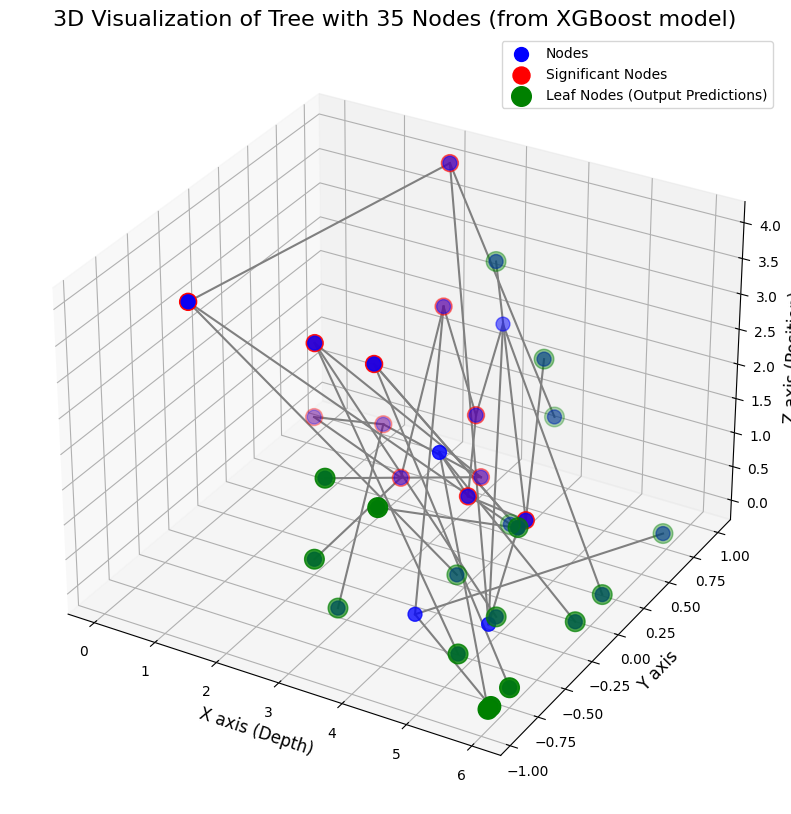

In [308]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Get feature importance based on gain
feature_importance = bst.get_score(importance_type='gain')

# Define a threshold for significant nodes (e.g., top 10% gain)
sorted_importance = sorted(feature_importance.values(), reverse=True)
importance_threshold = np.percentile(sorted_importance, 90)

# Extract the first tree from the model
tree_dump = bst.get_dump()

# Use the first tree and count the number of nodes
node_lines = tree_dump[0].split('\n')

# Store positions, connections, significant nodes, and leaf nodes
node_positions = []
connections = []
significant_nodes = []
leaf_nodes = []
node_depths = {}
max_depth = 0  # Track max depth

# Function to assign positions based on depth
def get_node_position(depth, max_depth):
    # Create a position based on depth (nodes at the same depth will be horizontally aligned)
    return np.array([depth, np.random.uniform(-1, 1), max_depth - depth])

# Parse the tree and extract positions, connections, and leaf nodes
for line_idx, line in enumerate(node_lines):
    if line.strip():  # Non-empty lines are nodes
        # Extract depth (indentation level) based on '\t' characters
        depth = line.count('\t')
        max_depth = max(max_depth, depth)

        # Assign position based on depth
        position = get_node_position(depth, max_depth)
        node_positions.append(position)
        node_depths[line_idx] = depth

        # Check for leaf nodes (these lines contain "leaf=")
        if 'leaf=' in line:
            leaf_nodes.append(line_idx)

        # Parse connection details (yes/no child nodes)
        if 'yes=' in line and 'no=' in line:
            yes_node = int(line.split('yes=')[1].split(',')[0])
            no_node = int(line.split('no=')[1].split(',')[0])
            # Add parent-child connections
            connections.append((line_idx, yes_node))
            connections.append((line_idx, no_node))

        # Check if this node's feature is in the top significant features based on gain
        if '[' in line and ']' in line:
            feature_str = line.split('[')[1].split('<')[0].strip()
            if feature_str in feature_importance and feature_importance[feature_str] >= importance_threshold:
                significant_nodes.append(line_idx)  # Mark this node as significant

n_nodes = len(node_positions)
print(f"Number of nodes in the first tree: {n_nodes}")
print(f"Number of leaf nodes (prediction outputs): {len(leaf_nodes)}")
print(f"Number of significant nodes: {len(significant_nodes)}")

# Create a 3D plot for the tree structure
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Convert node positions to numpy array for easier handling
node_positions = np.array(node_positions)

# Plot all nodes as blue points
ax.scatter(node_positions[:, 0], node_positions[:, 1], node_positions[:, 2], color='blue', s=100, label='Nodes')

# Plot significant nodes as red points
if significant_nodes:
    significant_node_positions = node_positions[significant_nodes]
    ax.scatter(significant_node_positions[:, 0], significant_node_positions[:, 1], significant_node_positions[:, 2], 
               color='red', s=150, label='Significant Nodes')

# Plot leaf nodes (prediction output nodes) as green points
if leaf_nodes:
    leaf_node_positions = node_positions[leaf_nodes]
    ax.scatter(leaf_node_positions[:, 0], leaf_node_positions[:, 1], leaf_node_positions[:, 2], 
               color='green', s=200, label='Leaf Nodes (Output Predictions)')

# Plot connections between parent-child nodes (tree branches)
for parent, child in connections:
    if parent < n_nodes and child < n_nodes:
        ax.plot([node_positions[parent, 0], node_positions[child, 0]],
                [node_positions[parent, 1], node_positions[child, 1]],
                [node_positions[parent, 2], node_positions[child, 2]], color='gray')

# Set axis labels
ax.set_title(f'3D Visualization of Tree with {n_nodes} Nodes (from XGBoost model)', fontsize=16)
ax.set_xlabel('X axis (Depth)', fontsize=12)
ax.set_ylabel('Y axis', fontsize=12)
ax.set_zlabel('Z axis (Position)', fontsize=12)

# Show legend and display the plot
ax.legend()
plt.show()

<h1 style="font-size:50px; color:white;">The combined structure of the top 20 most significant tree structures in the XGBoost model</h1>

Total number of nodes across the top trees: 574
Total number of leaf nodes (prediction outputs): 297
Total number of significant nodes: 138


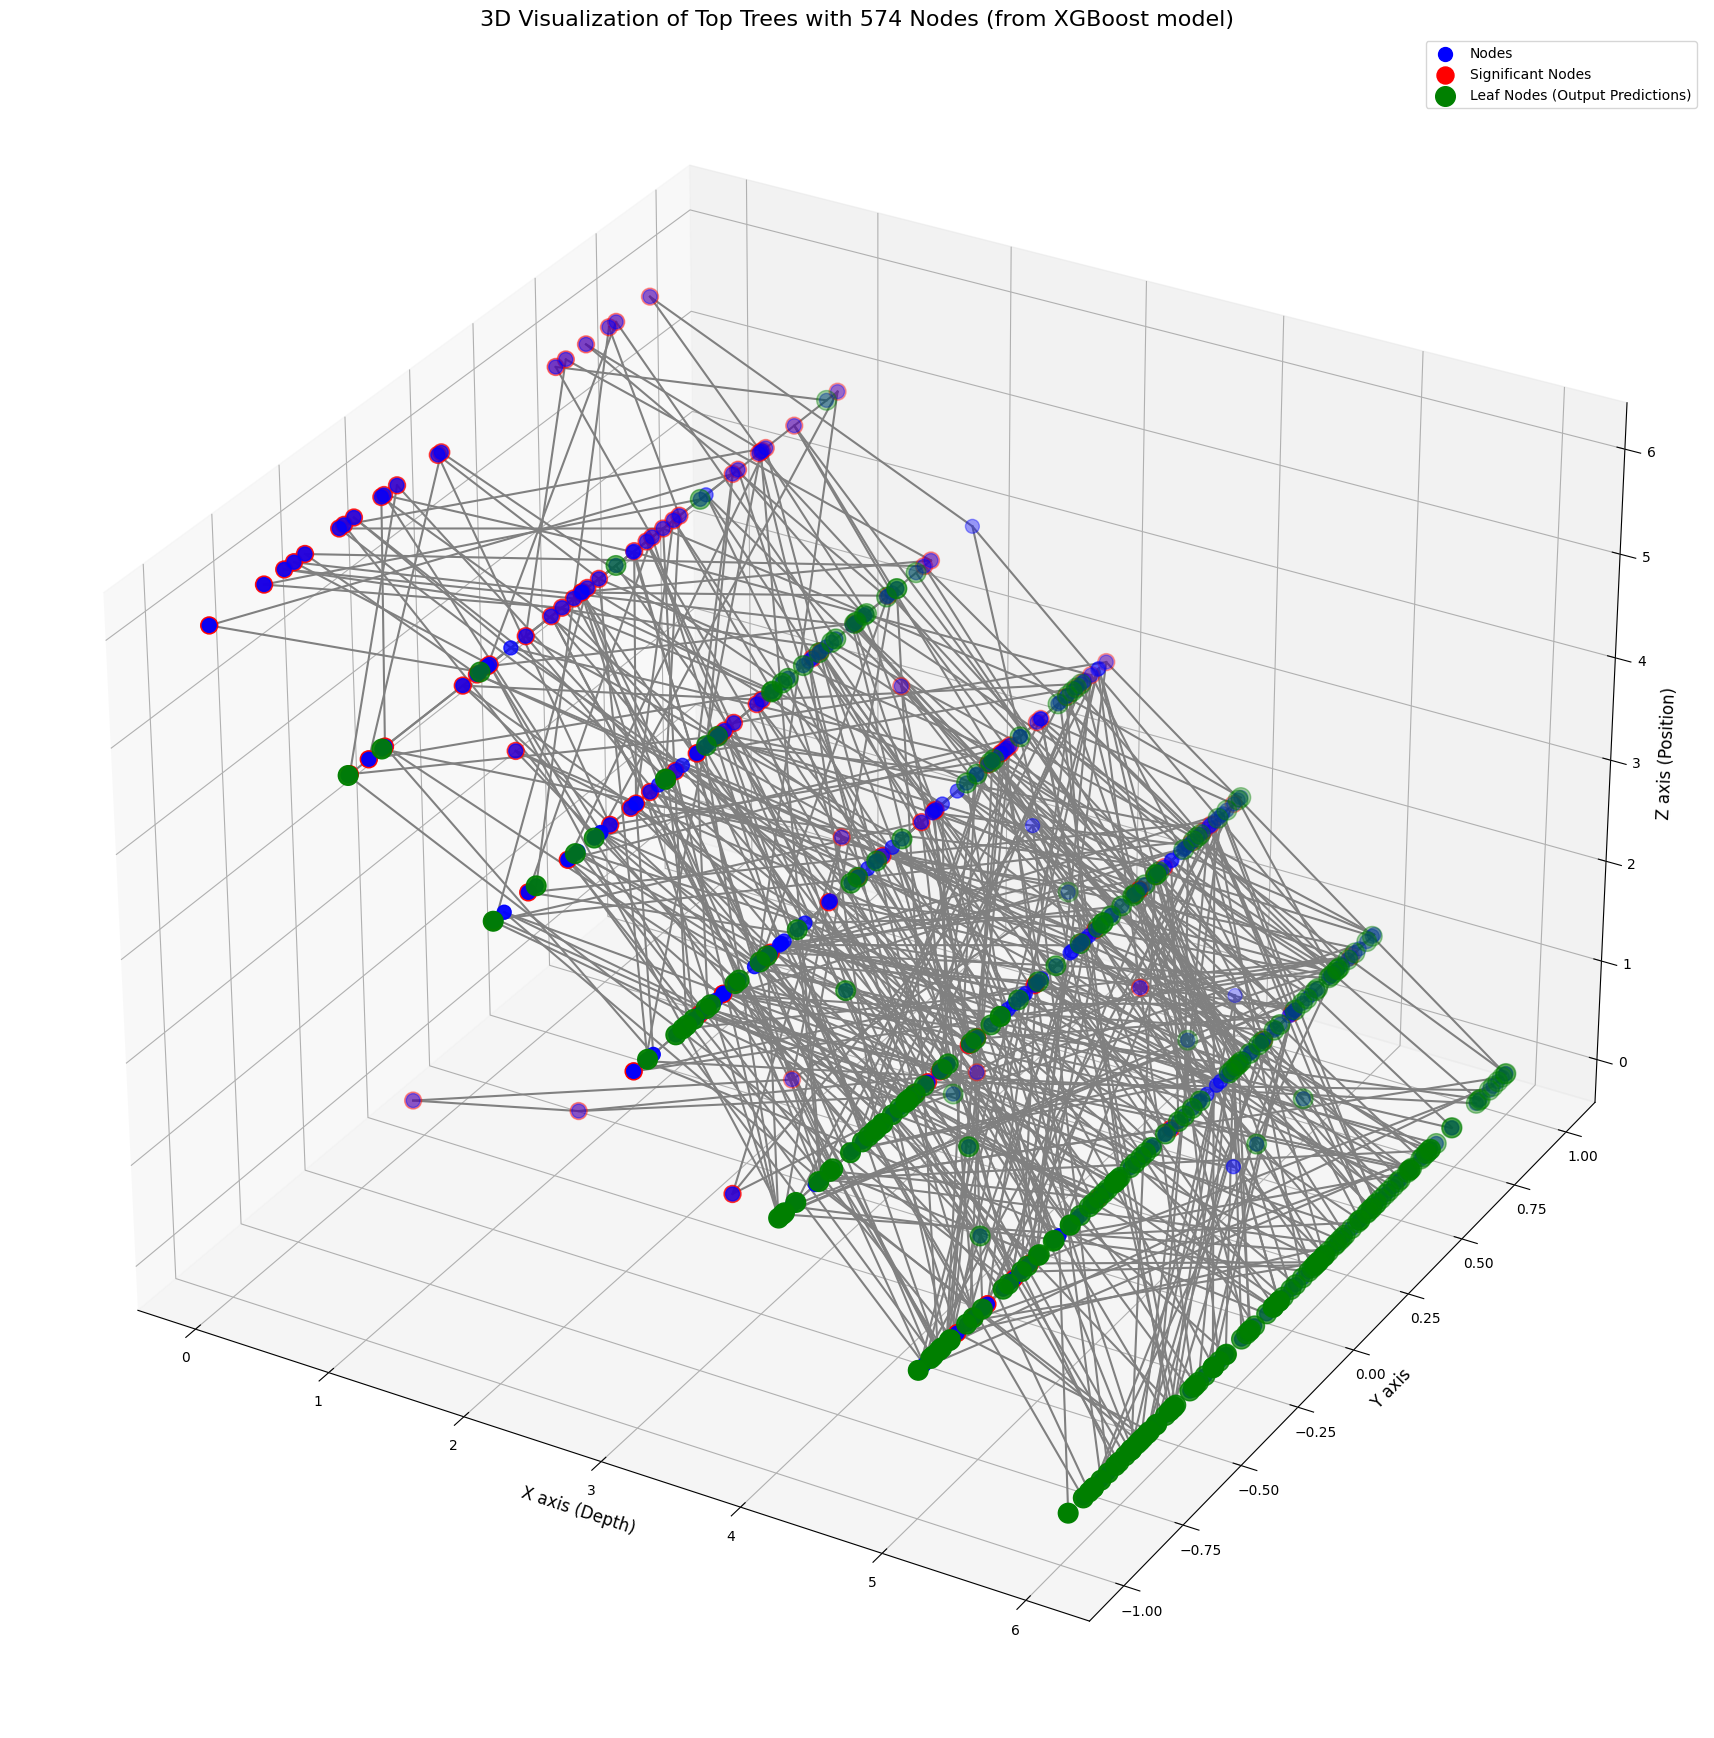

In [309]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Get feature importance based on gain
feature_importance = bst.get_score(importance_type='gain')

# Define a threshold for significant nodes (e.g., top 10% gain)
sorted_importance = sorted(feature_importance.values(), reverse=True)
importance_threshold = np.percentile(sorted_importance, 90)

# Extract all trees from the model
tree_dumps = bst.get_dump()

# Initialize variables to store all node positions, connections, and important nodes across trees
node_positions = []
connections = []
significant_nodes = []
leaf_nodes = []
global_node_idx = 0  # To uniquely identify nodes across multiple trees
max_depth = 0  # Track the maximum depth across all trees

# Function to assign positions based on depth
def get_node_position(depth, max_depth):
    # Create a position based on depth (nodes at the same depth will be horizontally aligned)
    return np.array([depth, np.random.uniform(-1, 1), max_depth - depth])

# Iterate over all trees and combine their nodes
for tree_idx, tree_dump in enumerate(tree_dumps[:20]):  # Process top 10 most significant trees (or adjust as needed)
    node_lines = tree_dump.split('\n')
    
    local_node_idx = 0  # Reset the local node index for each tree

    # Parse each tree and extract positions, connections, and leaf nodes
    for line_idx, line in enumerate(node_lines):
        if line.strip():  # Non-empty lines are nodes
            # Extract depth (indentation level) based on '\t' characters
            depth = line.count('\t')
            max_depth = max(max_depth, depth)

            # Assign position based on depth
            position = get_node_position(depth, max_depth)
            node_positions.append(position)

            # Check for leaf nodes (these lines contain "leaf=")
            if 'leaf=' in line:
                leaf_nodes.append(global_node_idx)

            # Parse connection details (yes/no child nodes)
            if 'yes=' in line and 'no=' in line:
                yes_node_local = int(line.split('yes=')[1].split(',')[0])
                no_node_local = int(line.split('no=')[1].split(',')[0])
                yes_node = global_node_idx + yes_node_local - local_node_idx  # Adjust based on current local node idx
                no_node = global_node_idx + no_node_local - local_node_idx
                # Add parent-child connections
                connections.append((global_node_idx, yes_node))
                connections.append((global_node_idx, no_node))

            # Check if this node's feature is in the top significant features based on gain
            if '[' in line and ']' in line:
                feature_str = line.split('[')[1].split('<')[0].strip()
                if feature_str in feature_importance and feature_importance[feature_str] >= importance_threshold:
                    significant_nodes.append(global_node_idx)  # Mark this node as significant

            local_node_idx += 1  # Increment local node index for this tree
            global_node_idx += 1  # Increment global node index across all trees

n_nodes = len(node_positions)
print(f"Total number of nodes across the top trees: {n_nodes}")
print(f"Total number of leaf nodes (prediction outputs): {len(leaf_nodes)}")
print(f"Total number of significant nodes: {len(significant_nodes)}")

# Create a 3D plot for the combined tree structures
fig = plt.figure(figsize=(22, 22))
ax = fig.add_subplot(111, projection='3d')

# Convert node positions to numpy array for easier handling
node_positions = np.array(node_positions)

# Plot all nodes as blue points
ax.scatter(node_positions[:, 0], node_positions[:, 1], node_positions[:, 2], color='blue', s=100, label='Nodes')

# Plot significant nodes as red points
if significant_nodes:
    significant_node_positions = node_positions[significant_nodes]
    ax.scatter(significant_node_positions[:, 0], significant_node_positions[:, 1], significant_node_positions[:, 2], 
               color='red', s=150, label='Significant Nodes')

# Plot leaf nodes (prediction output nodes) as green points
if leaf_nodes:
    leaf_node_positions = node_positions[leaf_nodes]
    ax.scatter(leaf_node_positions[:, 0], leaf_node_positions[:, 1], leaf_node_positions[:, 2], 
               color='green', s=200, label='Leaf Nodes (Output Predictions)')

# Plot connections between parent-child nodes (tree branches)
for parent, child in connections:
    if parent < n_nodes and child < n_nodes:
        ax.plot([node_positions[parent, 0], node_positions[child, 0]],
                [node_positions[parent, 1], node_positions[child, 1]],
                [node_positions[parent, 2], node_positions[child, 2]], color='gray')

# Set axis labels
ax.set_title(f'3D Visualization of Top Trees with {n_nodes} Nodes (from XGBoost model)', fontsize=16)
ax.set_xlabel('X axis (Depth)', fontsize=12)
ax.set_ylabel('Y axis', fontsize=12)
ax.set_zlabel('Z axis (Position)', fontsize=12)

# Show legend and display the plot
ax.legend()
plt.show()

<h1 style="font-size:50px; color:white;">A spherical representation of the xgboost's "neuronic structure" so to speak.</h1>

Total number of nodes across the top trees: 574
Total number of leaf nodes (prediction outputs): 297
Total number of significant nodes: 138


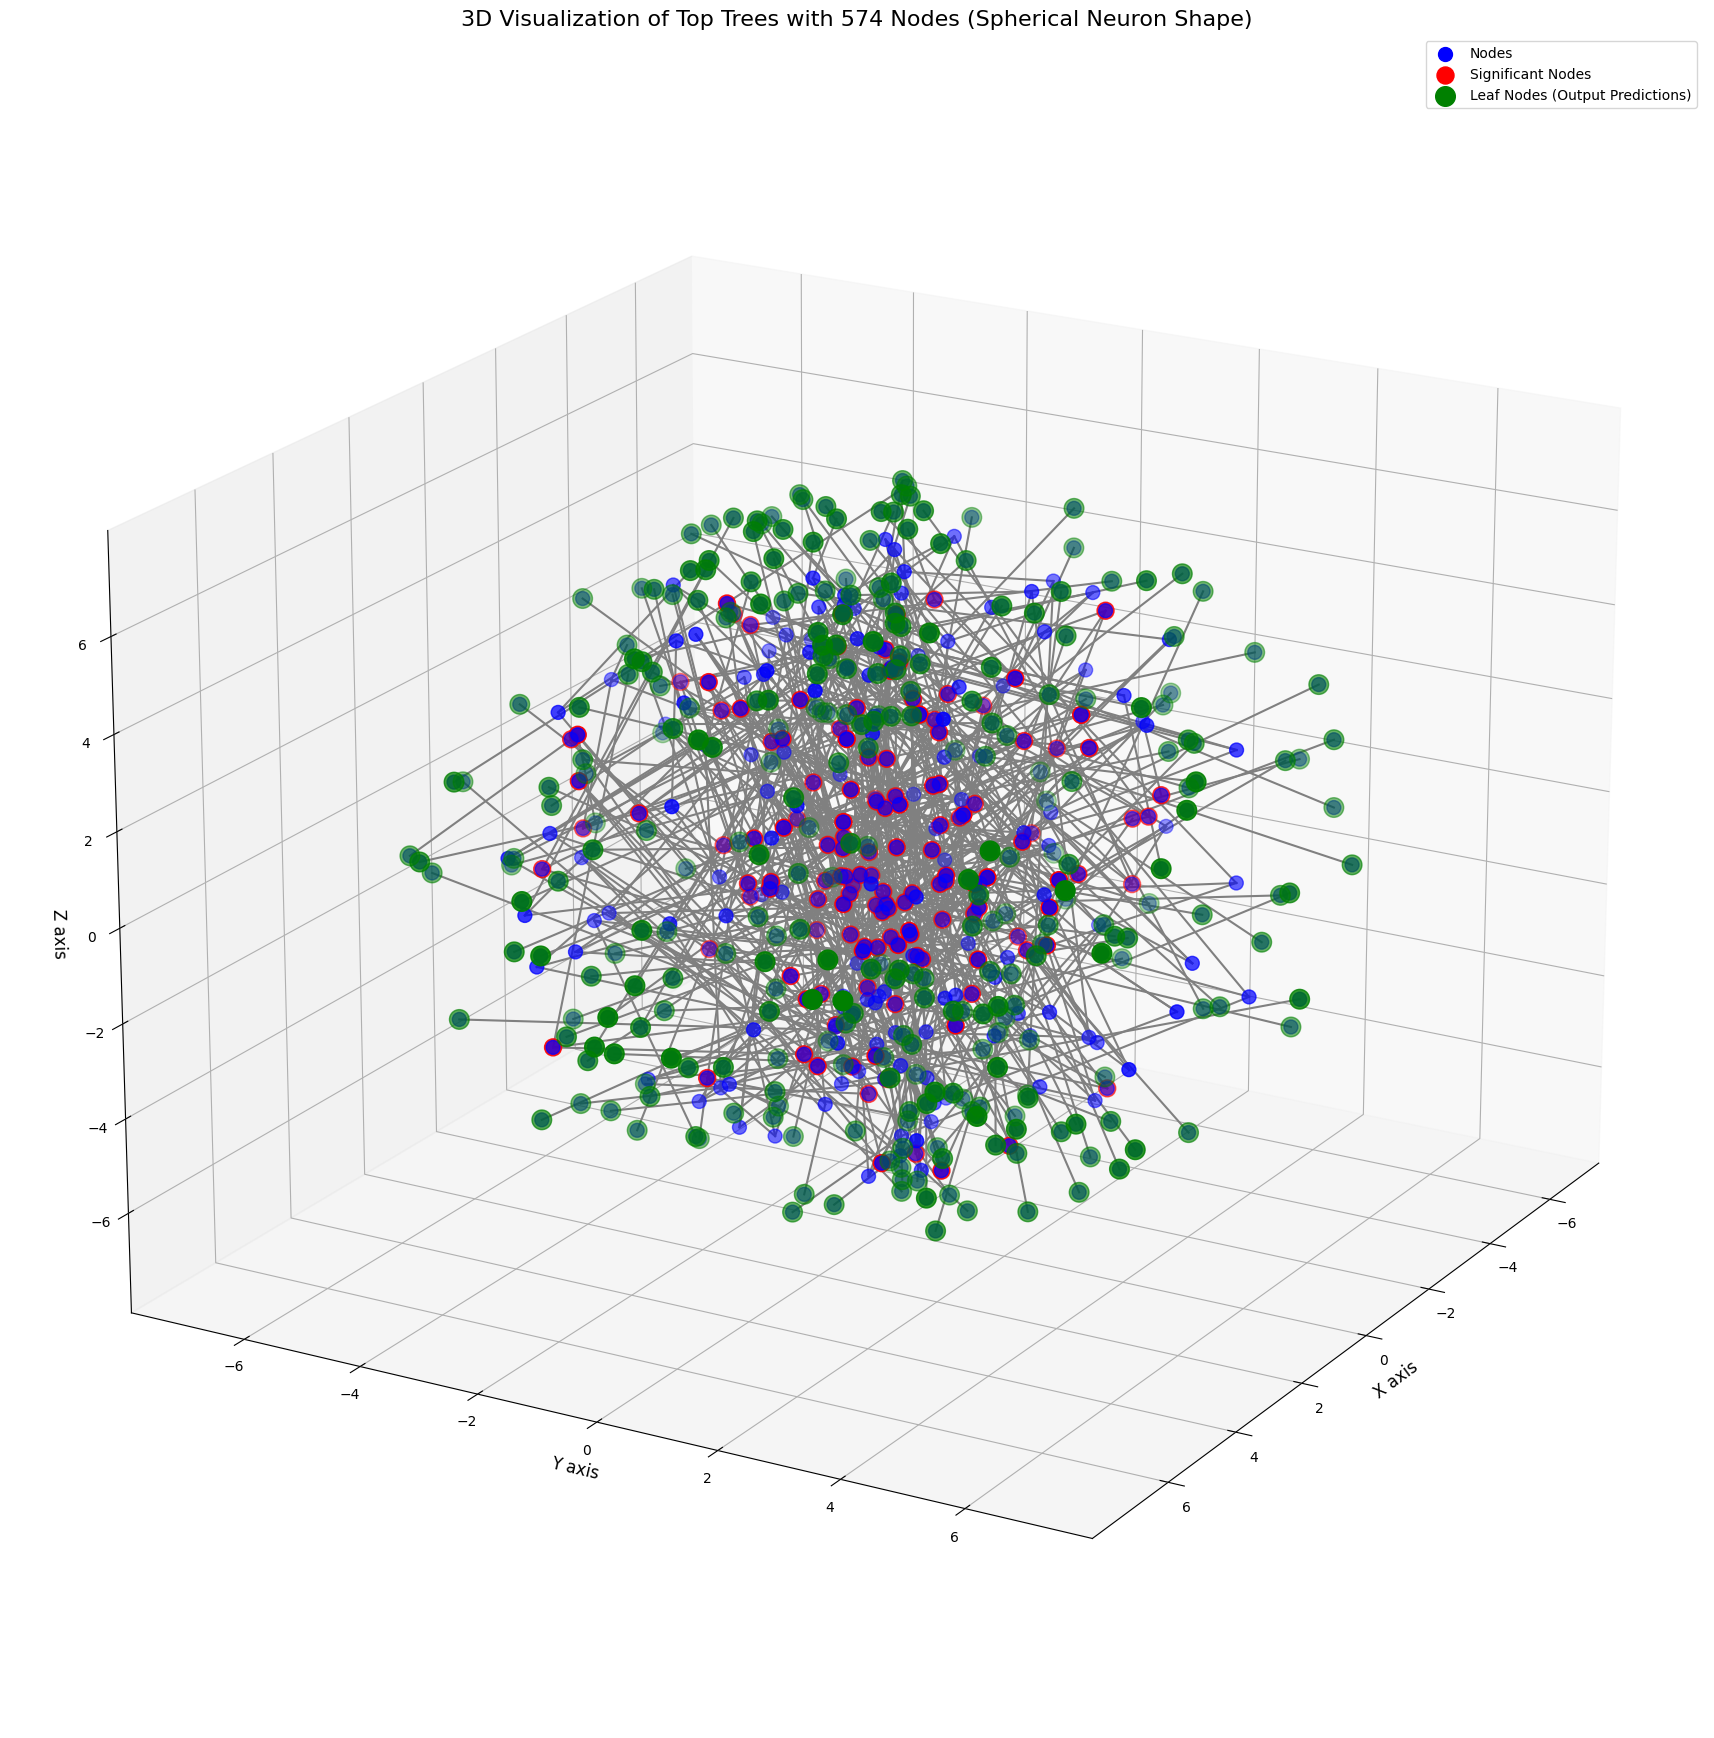

In [310]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Get feature importance based on gain
feature_importance = bst.get_score(importance_type='gain')

# Define a threshold for significant nodes (e.g., top 10% gain)
sorted_importance = sorted(feature_importance.values(), reverse=True)
importance_threshold = np.percentile(sorted_importance, 90)

# Extract all trees from the model
tree_dumps = bst.get_dump()

# Initialize variables to store all node positions, connections, and important nodes across trees
node_positions = []
connections = []
significant_nodes = []
leaf_nodes = []
global_node_idx = 0  # To uniquely identify nodes across multiple trees
max_depth = 0  # Track the maximum depth across all trees

# Function to assign positions based on depth and spherical coordinates with more curvature
def get_node_position(depth, max_depth, max_nodes):
    # Define spherical coordinates for nodes, adding curvature based on the depth
    radius = depth + 1 + np.random.uniform(-0.2, 0.2)  # Vary the radius slightly
    theta = np.random.uniform(0, 2 * np.pi)  # Azimuth angle
    phi = np.random.uniform(0, np.pi)  # Elevation angle

    # Convert spherical coordinates to Cartesian coordinates
    x = radius * np.sin(phi) * np.cos(theta)
    y = radius * np.sin(phi) * np.sin(theta)
    z = radius * np.cos(phi)
    
    return np.array([x, y, z])

# Iterate over all trees and combine their nodes
for tree_idx, tree_dump in enumerate(tree_dumps[:20]):  # Process top 10 most significant trees (or adjust as needed)
    node_lines = tree_dump.split('\n')
    
    local_node_idx = 0  # Reset the local node index for each tree

    # Parse each tree and extract positions, connections, and leaf nodes
    for line_idx, line in enumerate(node_lines):
        if line.strip():  # Non-empty lines are nodes
            # Extract depth (indentation level) based on '\t' characters
            depth = line.count('\t')
            max_depth = max(max_depth, depth)

            # Assign position based on spherical coordinates
            position = get_node_position(depth, max_depth, len(node_lines))
            node_positions.append(position)

            # Check for leaf nodes (these lines contain "leaf=")
            if 'leaf=' in line:
                leaf_nodes.append(global_node_idx)

            # Parse connection details (yes/no child nodes)
            if 'yes=' in line and 'no=' in line:
                yes_node_local = int(line.split('yes=')[1].split(',')[0])
                no_node_local = int(line.split('no=')[1].split(',')[0])
                yes_node = global_node_idx + yes_node_local - local_node_idx  # Adjust based on current local node idx
                no_node = global_node_idx + no_node_local - local_node_idx
                # Add parent-child connections
                connections.append((global_node_idx, yes_node))
                connections.append((global_node_idx, no_node))

            # Check if this node's feature is in the top significant features based on gain
            if '[' in line and ']' in line:
                feature_str = line.split('[')[1].split('<')[0].strip()
                if feature_str in feature_importance and feature_importance[feature_str] >= importance_threshold:
                    significant_nodes.append(global_node_idx)  # Mark this node as significant

            local_node_idx += 1  # Increment local node index for this tree
            global_node_idx += 1  # Increment global node index across all trees

n_nodes = len(node_positions)
print(f"Total number of nodes across the top trees: {n_nodes}")
print(f"Total number of leaf nodes (prediction outputs): {len(leaf_nodes)}")
print(f"Total number of significant nodes: {len(significant_nodes)}")

# Create a 3D plot for the combined tree structures
fig = plt.figure(figsize=(22, 22))
ax = fig.add_subplot(111, projection='3d')

# Convert node positions to numpy array for easier handling
node_positions = np.array(node_positions)

# Plot all nodes as blue points
ax.scatter(node_positions[:, 0], node_positions[:, 1], node_positions[:, 2], color='blue', s=100, label='Nodes')

# Plot significant nodes as red points
if significant_nodes:
    significant_node_positions = node_positions[significant_nodes]
    ax.scatter(significant_node_positions[:, 0], significant_node_positions[:, 1], significant_node_positions[:, 2], 
               color='red', s=150, label='Significant Nodes')

# Plot leaf nodes (prediction output nodes) as green points
if leaf_nodes:
    leaf_node_positions = node_positions[leaf_nodes]
    ax.scatter(leaf_node_positions[:, 0], leaf_node_positions[:, 1], leaf_node_positions[:, 2], 
               color='green', s=200, label='Leaf Nodes (Output Predictions)')

# Plot connections between parent-child nodes (tree branches)
for parent, child in connections:
    if parent < n_nodes and child < n_nodes:
        ax.plot([node_positions[parent, 0], node_positions[child, 0]],
                [node_positions[parent, 1], node_positions[child, 1]],
                [node_positions[parent, 2], node_positions[child, 2]], color='gray')

# Set axis labels
ax.set_title(f'3D Visualization of Top Trees with {n_nodes} Nodes (Spherical Neuron Shape)', fontsize=16)
ax.set_xlabel('X axis', fontsize=12)
ax.set_ylabel('Y axis', fontsize=12)
ax.set_zlabel('Z axis', fontsize=12)

# Set a specific camera angle for better curvature visibility
ax.view_init(elev=20, azim=30)

# Show legend and display the plot
ax.legend()
plt.show()

<h1 style="font-size:50px; color:white;">Brain neuron 3d model</h1>

Total number of nodes across the top trees: 574
Total number of leaf nodes (prediction outputs): 297
Total number of significant nodes: 138


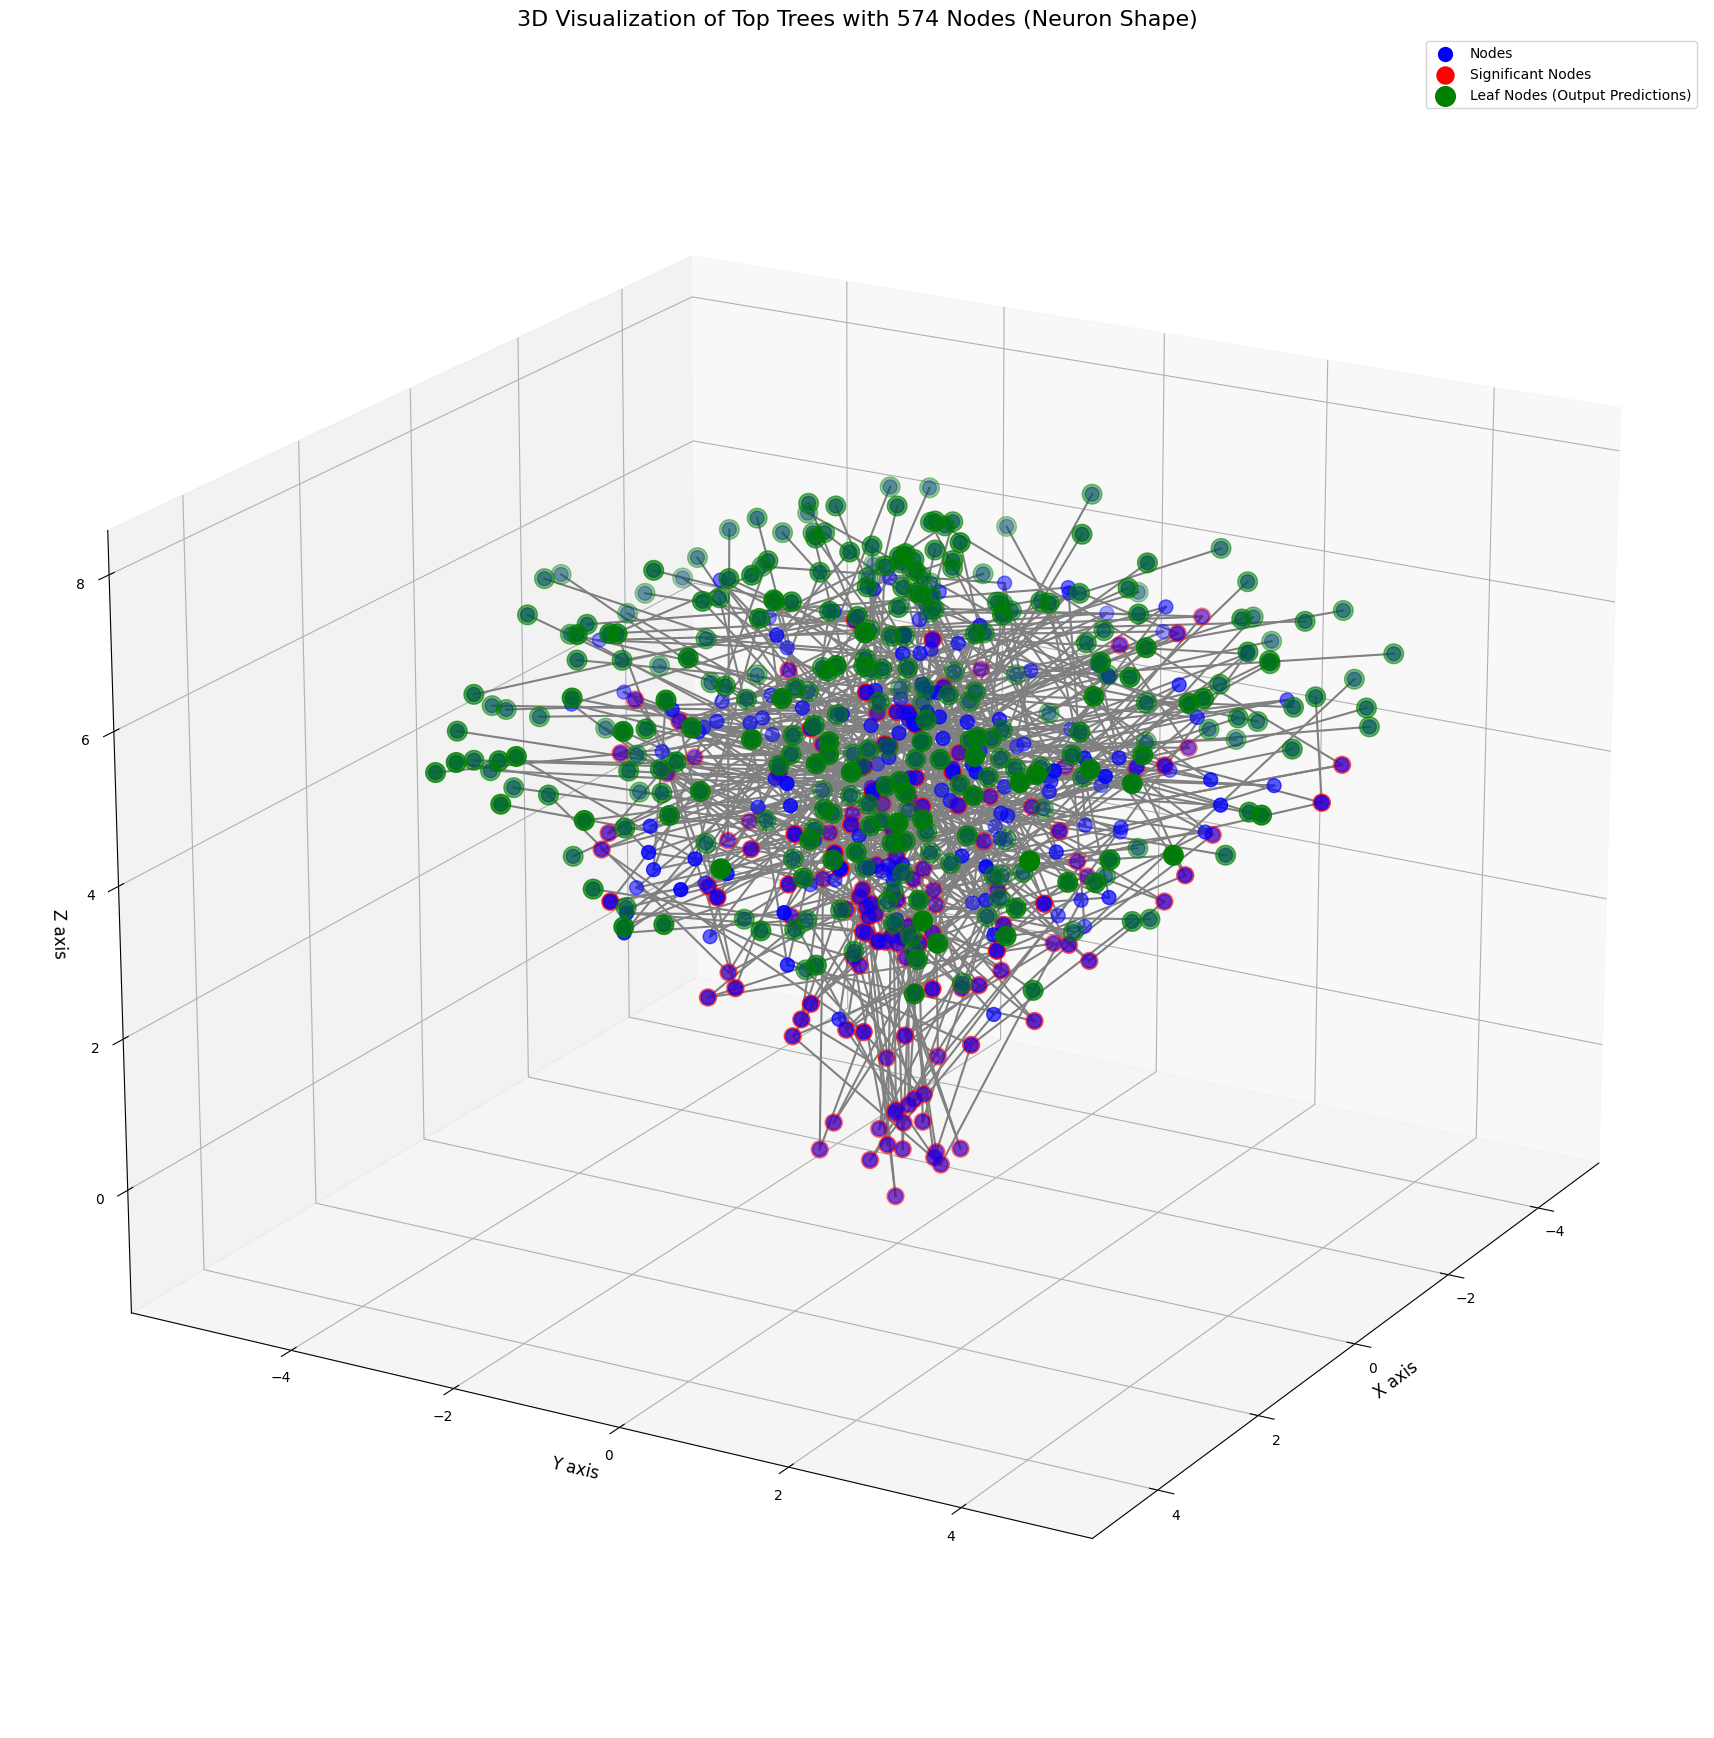

In [311]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Get feature importance based on gain
feature_importance = bst.get_score(importance_type='gain')

# Define a threshold for significant nodes (e.g., top 10% gain)
sorted_importance = sorted(feature_importance.values(), reverse=True)
importance_threshold = np.percentile(sorted_importance, 90)

# Extract all trees from the model
tree_dumps = bst.get_dump()

# Initialize variables to store all node positions, connections, and important nodes across trees
node_positions = []
connections = []
significant_nodes = []
leaf_nodes = []
global_node_idx = 0  # To uniquely identify nodes across multiple trees
max_depth = 0  # Track the maximum depth across all trees

# Function to assign positions to create neuron-like shape
def get_node_position(depth, max_depth, max_nodes, is_soma=False):
    if is_soma:
        # Soma: Dense central cluster (radius between 0 and 1)
        radius = np.random.uniform(0, 1)
        theta = np.random.uniform(0, 2 * np.pi)  # Azimuth angle
        phi = np.random.uniform(0, np.pi)  # Elevation angle
    else:
        # Dendrites/Axon: Branching, elongated structures
        radius = depth + np.random.uniform(1, 2)  # Elongated structure with radius increasing as depth increases
        theta = np.random.uniform(0, 2 * np.pi)  # Azimuth angle
        phi = np.random.uniform(0, np.pi / 4)  # Constrain elevation for branch-like appearance
    
    # Convert spherical coordinates to Cartesian coordinates
    x = radius * np.sin(phi) * np.cos(theta)
    y = radius * np.sin(phi) * np.sin(theta)
    z = radius * np.cos(phi)
    
    return np.array([x, y, z])

# Iterate over all trees and combine their nodes
for tree_idx, tree_dump in enumerate(tree_dumps[:20]):  # Process top 10 most significant trees (or adjust as needed)
    node_lines = tree_dump.split('\n')
    
    local_node_idx = 0  # Reset the local node index for each tree

    # Parse each tree and extract positions, connections, and leaf nodes
    for line_idx, line in enumerate(node_lines):
        if line.strip():  # Non-empty lines are nodes
            # Extract depth (indentation level) based on '\t' characters
            depth = line.count('\t')
            max_depth = max(max_depth, depth)

            # Assign position based on neuron-like shape (Soma for the first few nodes, dendrites/axon for others)
            is_soma = (depth == 0)  # First depth level represents the soma
            position = get_node_position(depth, max_depth, len(node_lines), is_soma)
            node_positions.append(position)

            # Check for leaf nodes (these lines contain "leaf=")
            if 'leaf=' in line:
                leaf_nodes.append(global_node_idx)

            # Parse connection details (yes/no child nodes)
            if 'yes=' in line and 'no=' in line:
                yes_node_local = int(line.split('yes=')[1].split(',')[0])
                no_node_local = int(line.split('no=')[1].split(',')[0])
                yes_node = global_node_idx + yes_node_local - local_node_idx  # Adjust based on current local node idx
                no_node = global_node_idx + no_node_local - local_node_idx
                # Add parent-child connections
                connections.append((global_node_idx, yes_node))
                connections.append((global_node_idx, no_node))

            # Check if this node's feature is in the top significant features based on gain
            if '[' in line and ']' in line:
                feature_str = line.split('[')[1].split('<')[0].strip()
                if feature_str in feature_importance and feature_importance[feature_str] >= importance_threshold:
                    significant_nodes.append(global_node_idx)  # Mark this node as significant

            local_node_idx += 1  # Increment local node index for this tree
            global_node_idx += 1  # Increment global node index across all trees

n_nodes = len(node_positions)
print(f"Total number of nodes across the top trees: {n_nodes}")
print(f"Total number of leaf nodes (prediction outputs): {len(leaf_nodes)}")
print(f"Total number of significant nodes: {len(significant_nodes)}")

# Create a 3D plot for the combined tree structures
fig = plt.figure(figsize=(22, 22))
ax = fig.add_subplot(111, projection='3d')

# Convert node positions to numpy array for easier handling
node_positions = np.array(node_positions)

# Plot all nodes as blue points
ax.scatter(node_positions[:, 0], node_positions[:, 1], node_positions[:, 2], color='blue', s=100, label='Nodes')

# Plot significant nodes as red points
if significant_nodes:
    significant_node_positions = node_positions[significant_nodes]
    ax.scatter(significant_node_positions[:, 0], significant_node_positions[:, 1], significant_node_positions[:, 2], 
               color='red', s=150, label='Significant Nodes')

# Plot leaf nodes (prediction output nodes) as green points
if leaf_nodes:
    leaf_node_positions = node_positions[leaf_nodes]
    ax.scatter(leaf_node_positions[:, 0], leaf_node_positions[:, 1], leaf_node_positions[:, 2], 
               color='green', s=200, label='Leaf Nodes (Output Predictions)')

# Plot connections between parent-child nodes (tree branches)
for parent, child in connections:
    if parent < n_nodes and child < n_nodes:
        ax.plot([node_positions[parent, 0], node_positions[child, 0]],
                [node_positions[parent, 1], node_positions[child, 1]],
                [node_positions[parent, 2], node_positions[child, 2]], color='gray')

# Set axis labels
ax.set_title(f'3D Visualization of Top Trees with {n_nodes} Nodes (Neuron Shape)', fontsize=16)
ax.set_xlabel('X axis', fontsize=12)
ax.set_ylabel('Y axis', fontsize=12)
ax.set_zlabel('Z axis', fontsize=12)

# Set a specific camera angle for better visibility
ax.view_init(elev=20, azim=30)

# Show legend and display the plot
ax.legend()
plt.show()

Total number of nodes across the top trees: 1474
Total number of leaf nodes (prediction outputs): 762
Total number of significant nodes: 349


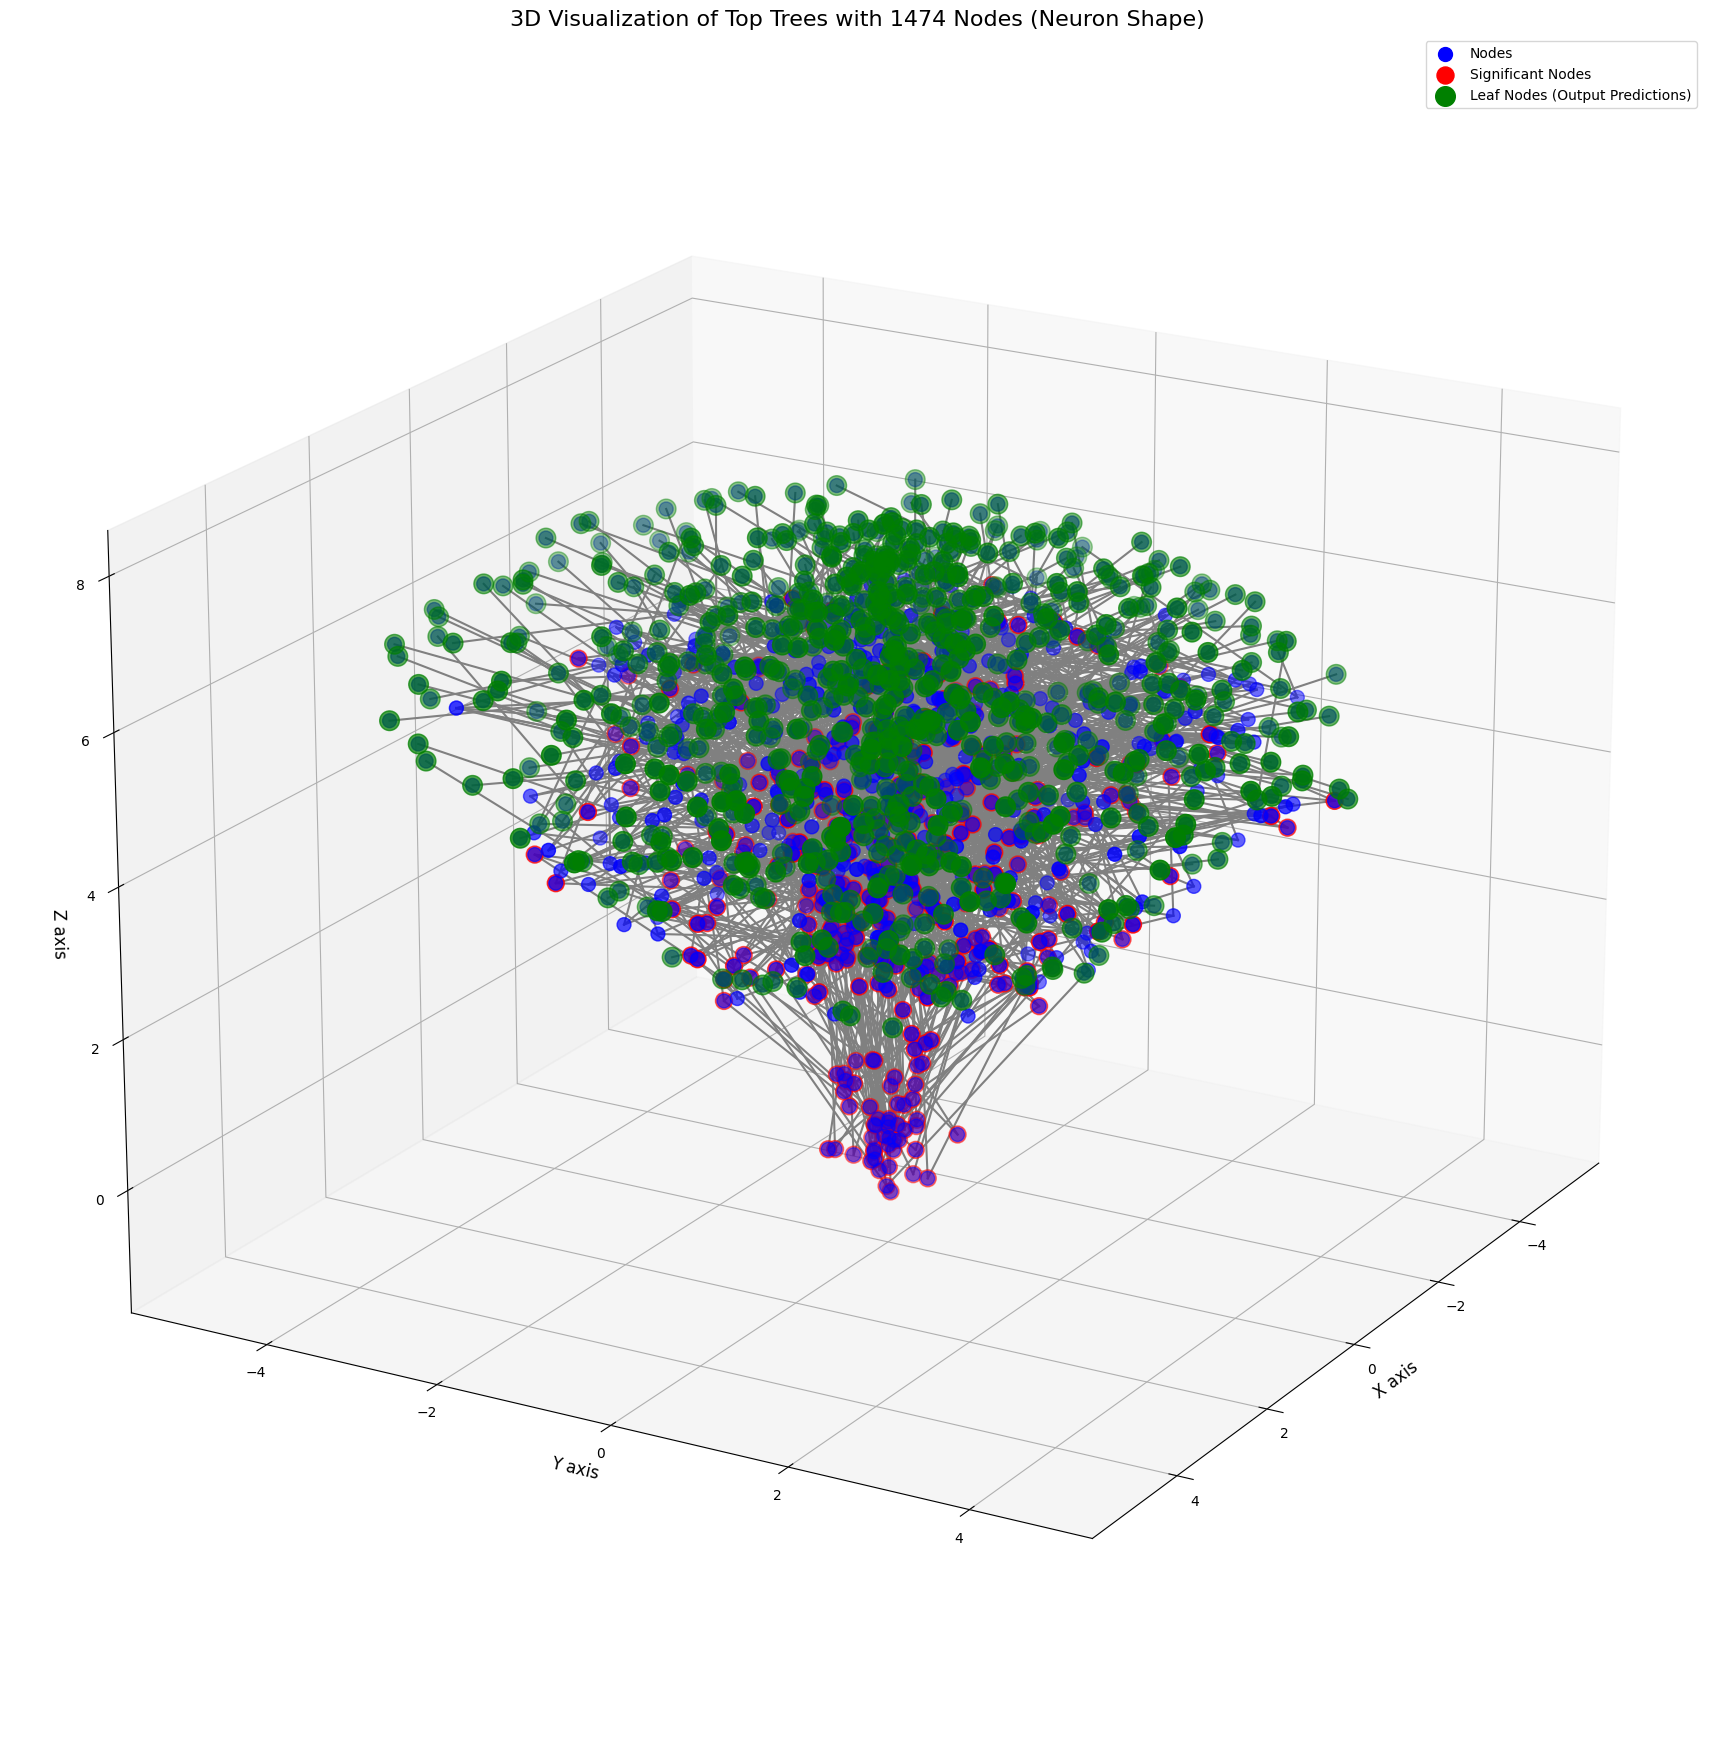

In [312]:
=import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Get feature importance based on gain
feature_importance = bst.get_score(importance_type='gain')

# Define a threshold for significant nodes (e.g., top 10% gain)
sorted_importance = sorted(feature_importance.values(), reverse=True)
importance_threshold = np.percentile(sorted_importance, 90)

# Extract all trees from the model
tree_dumps = bst.get_dump()

# Initialize variables to store all node positions, connections, and important nodes across trees
node_positions = []
connections = []
significant_nodes = []
leaf_nodes = []
global_node_idx = 0  # To uniquely identify nodes across multiple trees
max_depth = 0  # Track the maximum depth across all trees

# Function to assign positions to create neuron-like shape
def get_node_position(depth, max_depth, max_nodes, is_soma=False):
    if is_soma:
        # Soma: Dense central cluster (radius between 0 and 1)
        radius = np.random.uniform(0, 1)
        theta = np.random.uniform(0, 2 * np.pi)  # Azimuth angle
        phi = np.random.uniform(0, np.pi)  # Elevation angle
    else:
        # Dendrites/Axon: Branching, elongated structures
        radius = depth + np.random.uniform(1, 2)  # Elongated structure with radius increasing as depth increases
        theta = np.random.uniform(0, 2 * np.pi)  # Azimuth angle
        phi = np.random.uniform(0, np.pi / 4)  # Constrain elevation for branch-like appearance
    
    # Convert spherical coordinates to Cartesian coordinates
    x = radius * np.sin(phi) * np.cos(theta)
    y = radius * np.sin(phi) * np.sin(theta)
    z = radius * np.cos(phi)
    
    return np.array([x, y, z])

# Iterate over all trees and combine their nodes
for tree_idx, tree_dump in enumerate(tree_dumps[:50]):  # Process top 10 most significant trees (or adjust as needed)
    node_lines = tree_dump.split('\n')
    
    local_node_idx = 0  # Reset the local node index for each tree

    # Parse each tree and extract positions, connections, and leaf nodes
    for line_idx, line in enumerate(node_lines):
        if line.strip():  # Non-empty lines are nodes
            # Extract depth (indentation level) based on '\t' characters
            depth = line.count('\t')
            max_depth = max(max_depth, depth)

            # Assign position based on neuron-like shape (Soma for the first few nodes, dendrites/axon for others)
            is_soma = (depth == 0)  # First depth level represents the soma
            position = get_node_position(depth, max_depth, len(node_lines), is_soma)
            node_positions.append(position)

            # Check for leaf nodes (these lines contain "leaf=")
            if 'leaf=' in line:
                leaf_nodes.append(global_node_idx)

            # Parse connection details (yes/no child nodes)
            if 'yes=' in line and 'no=' in line:
                yes_node_local = int(line.split('yes=')[1].split(',')[0])
                no_node_local = int(line.split('no=')[1].split(',')[0])
                yes_node = global_node_idx + yes_node_local - local_node_idx  # Adjust based on current local node idx
                no_node = global_node_idx + no_node_local - local_node_idx
                # Add parent-child connections
                connections.append((global_node_idx, yes_node))
                connections.append((global_node_idx, no_node))

            # Check if this node's feature is in the top significant features based on gain
            if '[' in line and ']' in line:
                feature_str = line.split('[')[1].split('<')[0].strip()
                if feature_str in feature_importance and feature_importance[feature_str] >= importance_threshold:
                    significant_nodes.append(global_node_idx)  # Mark this node as significant

            local_node_idx += 1  # Increment local node index for this tree
            global_node_idx += 1  # Increment global node index across all trees

n_nodes = len(node_positions)
print(f"Total number of nodes across the top trees: {n_nodes}")
print(f"Total number of leaf nodes (prediction outputs): {len(leaf_nodes)}")
print(f"Total number of significant nodes: {len(significant_nodes)}")

# Create a 3D plot for the combined tree structures
fig = plt.figure(figsize=(22, 22))
ax = fig.add_subplot(111, projection='3d')

# Convert node positions to numpy array for easier handling
node_positions = np.array(node_positions)

# Plot all nodes as blue points
ax.scatter(node_positions[:, 0], node_positions[:, 1], node_positions[:, 2], color='blue', s=100, label='Nodes')

# Plot significant nodes as red points
if significant_nodes:
    significant_node_positions = node_positions[significant_nodes]
    ax.scatter(significant_node_positions[:, 0], significant_node_positions[:, 1], significant_node_positions[:, 2], 
               color='red', s=150, label='Significant Nodes')

# Plot leaf nodes (prediction output nodes) as green points
if leaf_nodes:
    leaf_node_positions = node_positions[leaf_nodes]
    ax.scatter(leaf_node_positions[:, 0], leaf_node_positions[:, 1], leaf_node_positions[:, 2], 
               color='green', s=200, label='Leaf Nodes (Output Predictions)')

# Plot connections between parent-child nodes (tree branches)
for parent, child in connections:
    if parent < n_nodes and child < n_nodes:
        ax.plot([node_positions[parent, 0], node_positions[child, 0]],
                [node_positions[parent, 1], node_positions[child, 1]],
                [node_positions[parent, 2], node_positions[child, 2]], color='gray')

# Set axis labels
ax.set_title(f'3D Visualization of Top Trees with {n_nodes} Nodes (Neuron Shape)', fontsize=16)
ax.set_xlabel('X axis', fontsize=12)
ax.set_ylabel('Y axis', fontsize=12)
ax.set_zlabel('Z axis', fontsize=12)

# Set a specific camera angle for better visibility
ax.view_init(elev=20, azim=30)

# Show legend and display the plot
ax.legend()
plt.show()

Total number of nodes across the top trees: 5860
Total number of leaf nodes (prediction outputs): 3030
Total number of significant nodes: 1339


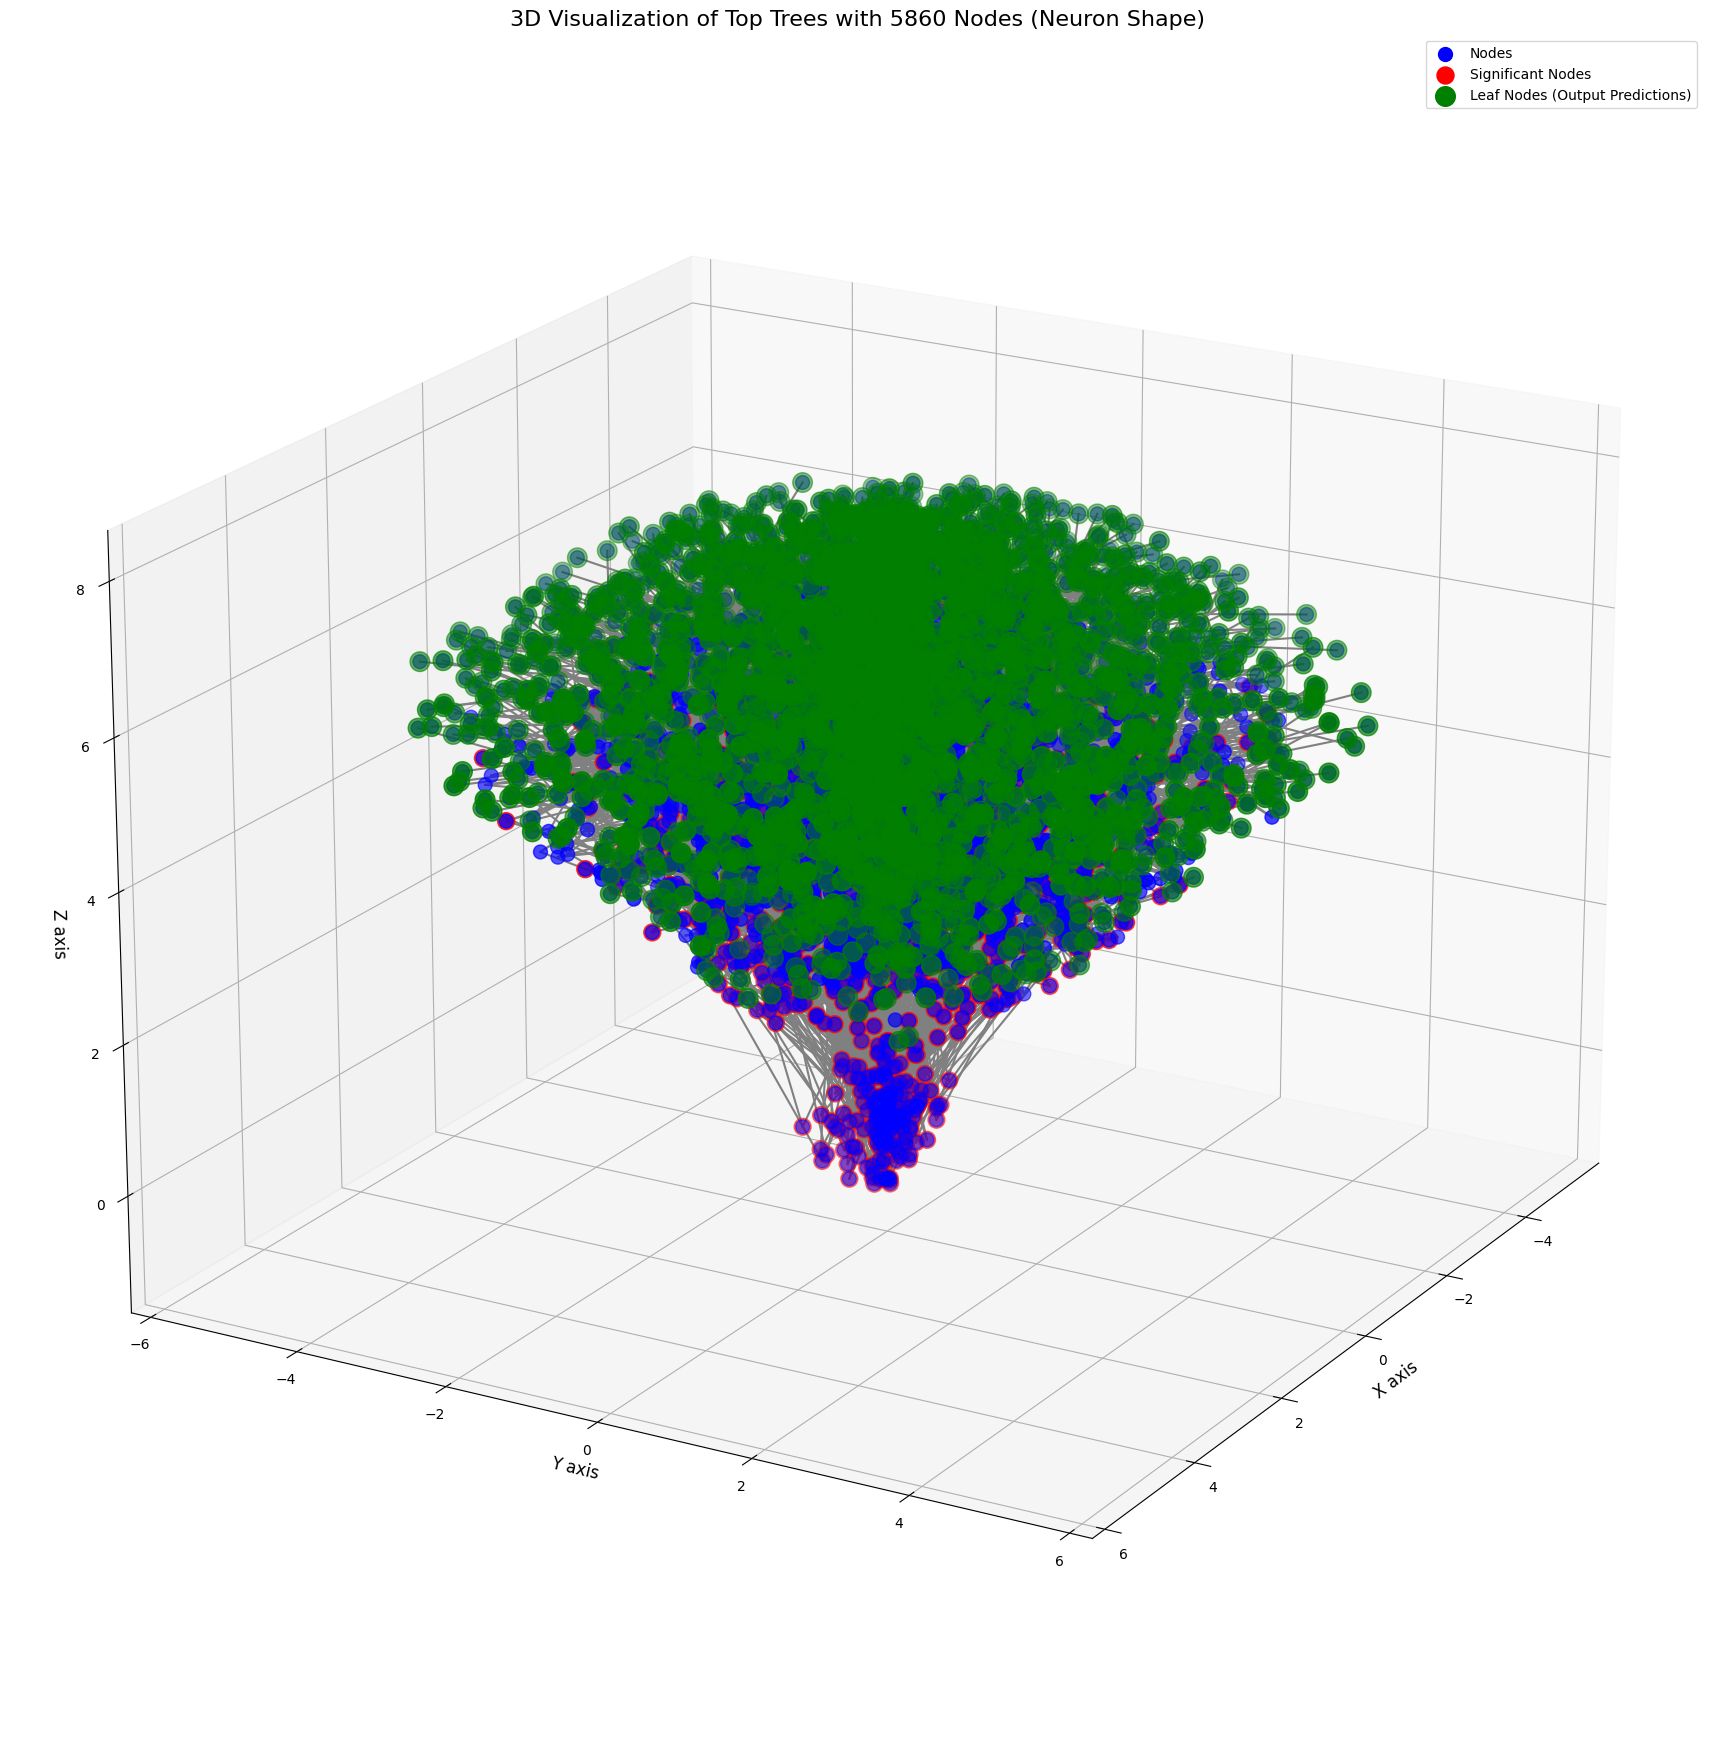

In [313]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Get feature importance based on gain
feature_importance = bst.get_score(importance_type='gain')

# Define a threshold for significant nodes (e.g., top 10% gain)
sorted_importance = sorted(feature_importance.values(), reverse=True)
importance_threshold = np.percentile(sorted_importance, 90)

# Extract all trees from the model
tree_dumps = bst.get_dump()

# Initialize variables to store all node positions, connections, and important nodes across trees
node_positions = []
connections = []
significant_nodes = []
leaf_nodes = []
global_node_idx = 0  # To uniquely identify nodes across multiple trees
max_depth = 0  # Track the maximum depth across all trees

# Function to assign positions to create neuron-like shape
def get_node_position(depth, max_depth, max_nodes, is_soma=False):
    if is_soma:
        # Soma: Dense central cluster (radius between 0 and 1)
        radius = np.random.uniform(0, 1)
        theta = np.random.uniform(0, 2 * np.pi)  # Azimuth angle
        phi = np.random.uniform(0, np.pi)  # Elevation angle
    else:
        # Dendrites/Axon: Branching, elongated structures
        radius = depth + np.random.uniform(1, 2)  # Elongated structure with radius increasing as depth increases
        theta = np.random.uniform(0, 2 * np.pi)  # Azimuth angle
        phi = np.random.uniform(0, np.pi / 4)  # Constrain elevation for branch-like appearance
    
    # Convert spherical coordinates to Cartesian coordinates
    x = radius * np.sin(phi) * np.cos(theta)
    y = radius * np.sin(phi) * np.sin(theta)
    z = radius * np.cos(phi)
    
    return np.array([x, y, z])

# Iterate over all trees and combine their nodes
for tree_idx, tree_dump in enumerate(tree_dumps[:200]):  # Process top 10 most significant trees (or adjust as needed)
    node_lines = tree_dump.split('\n')
    
    local_node_idx = 0  # Reset the local node index for each tree

    # Parse each tree and extract positions, connections, and leaf nodes
    for line_idx, line in enumerate(node_lines):
        if line.strip():  # Non-empty lines are nodes
            # Extract depth (indentation level) based on '\t' characters
            depth = line.count('\t')
            max_depth = max(max_depth, depth)

            # Assign position based on neuron-like shape (Soma for the first few nodes, dendrites/axon for others)
            is_soma = (depth == 0)  # First depth level represents the soma
            position = get_node_position(depth, max_depth, len(node_lines), is_soma)
            node_positions.append(position)

            # Check for leaf nodes (these lines contain "leaf=")
            if 'leaf=' in line:
                leaf_nodes.append(global_node_idx)

            # Parse connection details (yes/no child nodes)
            if 'yes=' in line and 'no=' in line:
                yes_node_local = int(line.split('yes=')[1].split(',')[0])
                no_node_local = int(line.split('no=')[1].split(',')[0])
                yes_node = global_node_idx + yes_node_local - local_node_idx  # Adjust based on current local node idx
                no_node = global_node_idx + no_node_local - local_node_idx
                # Add parent-child connections
                connections.append((global_node_idx, yes_node))
                connections.append((global_node_idx, no_node))

            # Check if this node's feature is in the top significant features based on gain
            if '[' in line and ']' in line:
                feature_str = line.split('[')[1].split('<')[0].strip()
                if feature_str in feature_importance and feature_importance[feature_str] >= importance_threshold:
                    significant_nodes.append(global_node_idx)  # Mark this node as significant

            local_node_idx += 1  # Increment local node index for this tree
            global_node_idx += 1  # Increment global node index across all trees

n_nodes = len(node_positions)
print(f"Total number of nodes across the top trees: {n_nodes}")
print(f"Total number of leaf nodes (prediction outputs): {len(leaf_nodes)}")
print(f"Total number of significant nodes: {len(significant_nodes)}")

# Create a 3D plot for the combined tree structures
fig = plt.figure(figsize=(22, 22))
ax = fig.add_subplot(111, projection='3d')

# Convert node positions to numpy array for easier handling
node_positions = np.array(node_positions)

# Plot all nodes as blue points
ax.scatter(node_positions[:, 0], node_positions[:, 1], node_positions[:, 2], color='blue', s=100, label='Nodes')

# Plot significant nodes as red points
if significant_nodes:
    significant_node_positions = node_positions[significant_nodes]
    ax.scatter(significant_node_positions[:, 0], significant_node_positions[:, 1], significant_node_positions[:, 2], 
               color='red', s=150, label='Significant Nodes')

# Plot leaf nodes (prediction output nodes) as green points
if leaf_nodes:
    leaf_node_positions = node_positions[leaf_nodes]
    ax.scatter(leaf_node_positions[:, 0], leaf_node_positions[:, 1], leaf_node_positions[:, 2], 
               color='green', s=200, label='Leaf Nodes (Output Predictions)')

# Plot connections between parent-child nodes (tree branches)
for parent, child in connections:
    if parent < n_nodes and child < n_nodes:
        ax.plot([node_positions[parent, 0], node_positions[child, 0]],
                [node_positions[parent, 1], node_positions[child, 1]],
                [node_positions[parent, 2], node_positions[child, 2]], color='gray')

# Set axis labels
ax.set_title(f'3D Visualization of Top Trees with {n_nodes} Nodes (Neuron Shape)', fontsize=16)
ax.set_xlabel('X axis', fontsize=12)
ax.set_ylabel('Y axis', fontsize=12)
ax.set_zlabel('Z axis', fontsize=12)

# Set a specific camera angle for better visibility
ax.view_init(elev=20, azim=30)

# Show legend and display the plot
ax.legend()
plt.show()

Total number of nodes across the top trees: 8537
Total number of leaf nodes (prediction outputs): 4418
Total number of significant nodes: 1935


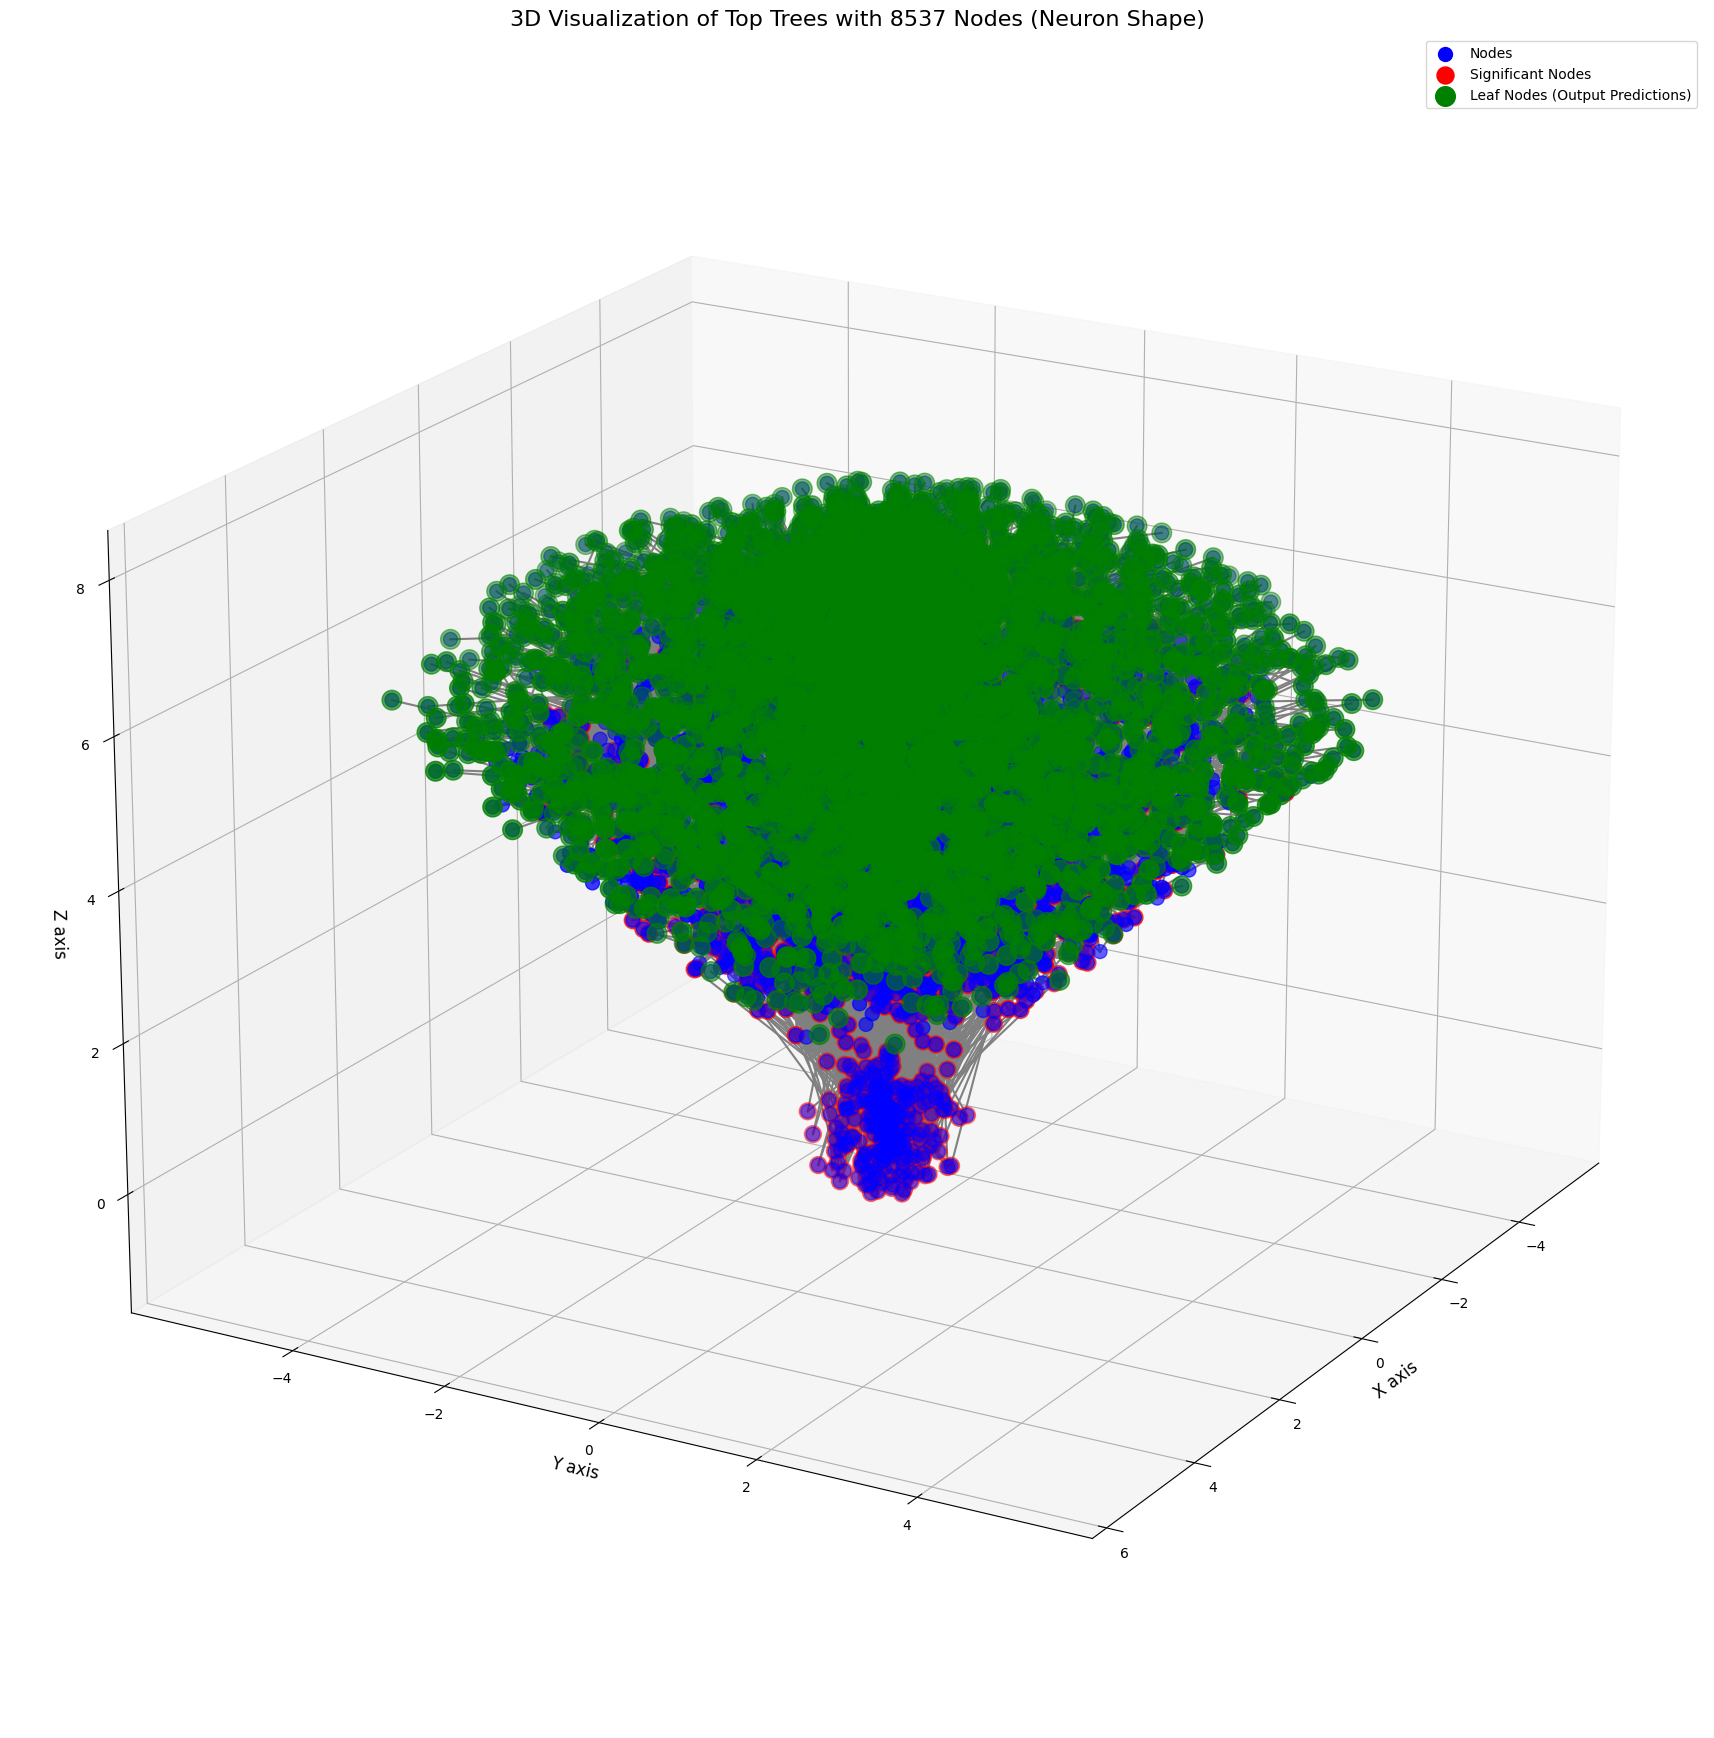

In [314]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Get feature importance based on gain
feature_importance = bst.get_score(importance_type='gain')

# Define a threshold for significant nodes (e.g., top 10% gain)
sorted_importance = sorted(feature_importance.values(), reverse=True)
importance_threshold = np.percentile(sorted_importance, 90)

# Extract all trees from the model
tree_dumps = bst.get_dump()

# Initialize variables to store all node positions, connections, and important nodes across trees
node_positions = []
connections = []
significant_nodes = []
leaf_nodes = []
global_node_idx = 0  # To uniquely identify nodes across multiple trees
max_depth = 0  # Track the maximum depth across all trees

# Function to assign positions to create neuron-like shape
def get_node_position(depth, max_depth, max_nodes, is_soma=False):
    if is_soma:
        # Soma: Dense central cluster (radius between 0 and 1)
        radius = np.random.uniform(0, 1)
        theta = np.random.uniform(0, 2 * np.pi)  # Azimuth angle
        phi = np.random.uniform(0, np.pi)  # Elevation angle
    else:
        # Dendrites/Axon: Branching, elongated structures
        radius = depth + np.random.uniform(1, 2)  # Elongated structure with radius increasing as depth increases
        theta = np.random.uniform(0, 2 * np.pi)  # Azimuth angle
        phi = np.random.uniform(0, np.pi / 4)  # Constrain elevation for branch-like appearance
    
    # Convert spherical coordinates to Cartesian coordinates
    x = radius * np.sin(phi) * np.cos(theta)
    y = radius * np.sin(phi) * np.sin(theta)
    z = radius * np.cos(phi)
    
    return np.array([x, y, z])

# Iterate over all trees and combine their nodes
for tree_idx, tree_dump in enumerate(tree_dumps[:299]):  # Process top 10 most significant trees (or adjust as needed)
    node_lines = tree_dump.split('\n')
    
    local_node_idx = 0  # Reset the local node index for each tree

    # Parse each tree and extract positions, connections, and leaf nodes
    for line_idx, line in enumerate(node_lines):
        if line.strip():  # Non-empty lines are nodes
            # Extract depth (indentation level) based on '\t' characters
            depth = line.count('\t')
            max_depth = max(max_depth, depth)

            # Assign position based on neuron-like shape (Soma for the first few nodes, dendrites/axon for others)
            is_soma = (depth == 0)  # First depth level represents the soma
            position = get_node_position(depth, max_depth, len(node_lines), is_soma)
            node_positions.append(position)

            # Check for leaf nodes (these lines contain "leaf=")
            if 'leaf=' in line:
                leaf_nodes.append(global_node_idx)

            # Parse connection details (yes/no child nodes)
            if 'yes=' in line and 'no=' in line:
                yes_node_local = int(line.split('yes=')[1].split(',')[0])
                no_node_local = int(line.split('no=')[1].split(',')[0])
                yes_node = global_node_idx + yes_node_local - local_node_idx  # Adjust based on current local node idx
                no_node = global_node_idx + no_node_local - local_node_idx
                # Add parent-child connections
                connections.append((global_node_idx, yes_node))
                connections.append((global_node_idx, no_node))

            # Check if this node's feature is in the top significant features based on gain
            if '[' in line and ']' in line:
                feature_str = line.split('[')[1].split('<')[0].strip()
                if feature_str in feature_importance and feature_importance[feature_str] >= importance_threshold:
                    significant_nodes.append(global_node_idx)  # Mark this node as significant

            local_node_idx += 1  # Increment local node index for this tree
            global_node_idx += 1  # Increment global node index across all trees

n_nodes = len(node_positions)
print(f"Total number of nodes across the top trees: {n_nodes}")
print(f"Total number of leaf nodes (prediction outputs): {len(leaf_nodes)}")
print(f"Total number of significant nodes: {len(significant_nodes)}")

# Create a 3D plot for the combined tree structures
fig = plt.figure(figsize=(22, 22))
ax = fig.add_subplot(111, projection='3d')

# Convert node positions to numpy array for easier handling
node_positions = np.array(node_positions)

# Plot all nodes as blue points
ax.scatter(node_positions[:, 0], node_positions[:, 1], node_positions[:, 2], color='blue', s=100, label='Nodes')

# Plot significant nodes as red points
if significant_nodes:
    significant_node_positions = node_positions[significant_nodes]
    ax.scatter(significant_node_positions[:, 0], significant_node_positions[:, 1], significant_node_positions[:, 2], 
               color='red', s=150, label='Significant Nodes')

# Plot leaf nodes (prediction output nodes) as green points
if leaf_nodes:
    leaf_node_positions = node_positions[leaf_nodes]
    ax.scatter(leaf_node_positions[:, 0], leaf_node_positions[:, 1], leaf_node_positions[:, 2], 
               color='green', s=200, label='Leaf Nodes (Output Predictions)')

# Plot connections between parent-child nodes (tree branches)
for parent, child in connections:
    if parent < n_nodes and child < n_nodes:
        ax.plot([node_positions[parent, 0], node_positions[child, 0]],
                [node_positions[parent, 1], node_positions[child, 1]],
                [node_positions[parent, 2], node_positions[child, 2]], color='gray')

# Set axis labels
ax.set_title(f'3D Visualization of Top Trees with {n_nodes} Nodes (Neuron Shape)', fontsize=16)
ax.set_xlabel('X axis', fontsize=12)
ax.set_ylabel('Y axis', fontsize=12)
ax.set_zlabel('Z axis', fontsize=12)

# Set a specific camera angle for better visibility
ax.view_init(elev=20, azim=30)

# Show legend and display the plot
ax.legend()
plt.show()

In [315]:
# The total number of trees in the trained XGBoost model
num_trees = bst.best_iteration if bst.attr('best_iteration') else 300  # Use best_iteration if early stopping, else 300 (defined in num_boost_round)
print(f"Total number of trees in the XGBoost model: {num_trees}")

Total number of trees in the XGBoost model: 298
